# KBMOD Search for Multi-Night Results
  
A basic notebook to demonstrate searching results that appear across multiple nights.

Note that this notebook is intended to be run using shared data on baldur.

# Setup demo

Before importing, make sure you have installed kbmod using `pip install .` in the root `KBMOD` directory.  Also be sure you are running with python3 and using the correct notebook kernel.

In [35]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os

import kbmod
from kbmod.analysis.plotting import *
from kbmod.data_interface import load_deccam_layered_image
from kbmod.search import ImageStack, PSF, StampCreator, Trajectory
from kbmod.results import Results
from kbmod.work_unit import WorkUnit
from kbmod.trajectory_generator import VelocityGridSearch
from kbmod.trajectory_utils import trajectory_predict_skypos

from kbmod.trajectory_explorer import TrajectoryExplorer

from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u
from astropy.table import Table
import astropy.time 

import pandas as pd

In [5]:
# Data paths
wu_path = "/epyc/projects/kbmod/runs/awoldag/reprojected_wu.fits"  # A reflex-corrected WorkUnit
res_path = "/epyc/projects/kbmod/runs/awoldag"

# Path to known fakes (with reflex-corrected) coordinates on the dates used in this KBMOD search.
fakes_path = "/epyc/projects/kbmod/runs/wbeebe/fakes_42_au_2019_04_02_and_2019_05_07.csv"

known_objects_path = "/epyc/projects/kbmod/runs/wbeebe/region_search_df_A0_differenceExp_skybot_clean_simple.csv"

# Reload a Saved KBMOD WorkUnit
Note that this WorkUnit was reflex-corrected with a guess distance of 42 AU.

By reloading the WorkUnit, we're able to recreate the stamps for individual observations in any given trajectory

In [6]:
wu = WorkUnit.from_fits(wu_path)

stack = wu.im_stack

print(f"Loaded stack with {stack.img_count()} images")

Setting unknown parameter: cluster_function
Setting unknown parameter: num_cores


Loaded stack with 189 images


# Reload KBMOD Results

A KBMOD run will store several files in its results directory. But we can generate a `Results` object (which wraps an astropy Table) from the `results.ecsv`

In [8]:
results = Results.read_table(os.path.join(res_path, "results.ecsv"))
results

<Results length=1096>
  x     y            vx         ...   obs_valid             stamp          
int64 int64       float64       ...   bool[189]         float32[21,21]     
----- ----- ------------------- ... -------------- ------------------------
 1313  2677 -167.92662048339844 ... False .. False  82.311584 .. -132.04692
 1313  2678  -167.8735809326172 ... False .. False    82.32074 .. -92.52377
 1313  2676 -167.92100524902344 ... False .. False   81.34648 .. -258.50363
 1313  2679  -168.0902862548828 ... False .. False    82.33218 .. -81.25874
 1313  2681 -168.31124877929688 ... False .. False 79.764984 .. -114.542244
 1313  2682 -167.86314392089844 ... False .. False  79.773285 .. -101.86222
 1312  2677  -145.4580841064453 ... False .. False    84.7464 .. -132.55171
 1312  2678  -145.4947967529297 ... False .. False     82.34671 .. -118.174
 1312  2679 -145.48948669433594 ... False .. False    82.37084 .. -92.94175
  ...   ...                 ... ...            ...                      ...
  967  2485 -165.51803588867188 ...  True .. False -119.85851 .. -190.06256
 1403  3226 -255.58905029296875 ...  True .. False  118.95177 .. -376.65985
 3360  3508  -209.5409393310547 ...  True .. False     399.5096 .. 73.76016
 4147  4434 -16.288166046142578 ...  True .. False    51.59689 .. 236.52283
  593  2543 -128.87733459472656 ...  True .. False    6.361621 .. 43.705544
   52  3920  -386.1593933105469 ...  True .. False  -323.64185 .. -537.7208
 2411  1803  -329.4836120605469 ...  True .. False   -57.72212 .. -73.60541
  998  1812  -124.0913314819336 ...  True .. False  -9.091747 .. -2.0963912
 4444  3102  -383.4205627441406 ...  True .. False   115.44487 .. -115.0944
 4443  3105  -368.0640869140625 ...  True .. False  -231.34825 .. -57.73217

Let's reconstruct the trajectories from our saved results and recreate the stamps for each observation

In [9]:
trajectories = results.make_trajectory_list()
results.table["all_stamps"] = [StampCreator.get_stamps(stack, trj, 10) for trj in trajectories]

Add a column to our results for the number of unique days observed for each result based on the MJDs 

In [10]:
def mjd_to_day(mjd):
    # Takes a float mjd and converts to a string calendar date
    return str(astropy.time.Time(mjd, format='mjd').to_value('datetime')).split()[0]

# For each result find the number of unique days observed.
num_days = []
for idx in range(len(results)):
    # Whether an observation was "valid" and included in the result
    is_valid = results[idx]["obs_valid"]
    
    # Get all of the observation times that were valid and included in the result
    valid_obstimes = [] 
    for i in range(len(is_valid)):
        if is_valid[i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    # Convert the obstimes to days and generate the number of days.
    num_days.append(len(set([mjd_to_day(t) for t in valid_obstimes])))

# Add as a column in the results table
results.table["num_days"] = num_days

Now for each result, we're interested in plotting the cumulative coadd as well as the coadds consisting only of the observations within a given day for that result.

In [51]:
# Generate coadds per each day to sanity check against the fakes.
def plot_daily_coadds(result_table, result_idx):
    # Map each day for a result to its coadded stamp
    daily_coadds = {}
    result_row = result_table[result_idx]
    for i in range(stack.img_count()):
        if result_row["obs_valid"][i]:
            day = mjd_to_day(stack.get_obstime(i))
            curr_stamp = result_row["all_stamps"][i]
            # Depending on where "all_stamps" is generated may be a RawImage
            if not isinstance(curr_stamp, np.ndarray):
                curr_stamp = curr_stamp.image

            if day not in daily_coadds:
                # Create the initial coadd
                daily_coadds[day] = curr_stamp.copy()
            else:
                # Add the stamps together
                daily_coadds[day] += curr_stamp
    
    # First we'll plot the full coadd
    imgs = [result_table["stamp"][result_idx]]
    labels = [f'Coadd for result {result_idx}']
    
    # Add images and labels for each individual day
    for day in daily_coadds:
        imgs.append(daily_coadds[day])
        labels.append(str(day))
    
    plot_multiple_images(imgs, labels=labels, norm=True)

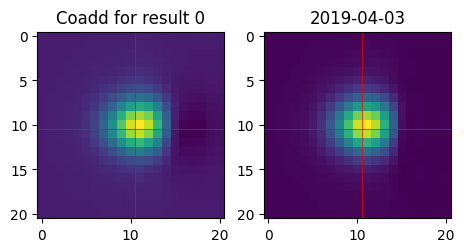

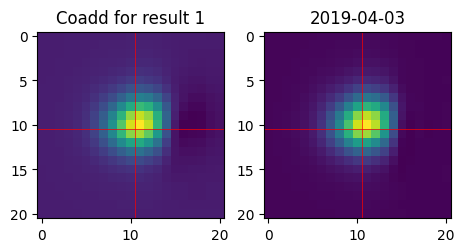

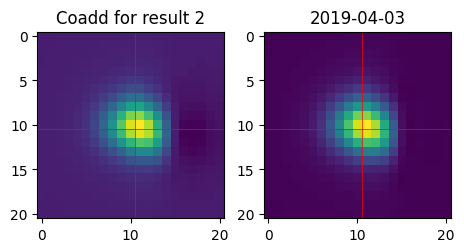

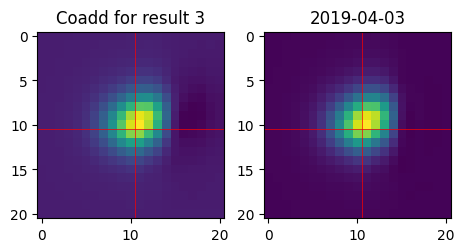

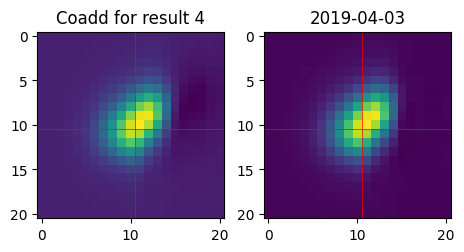

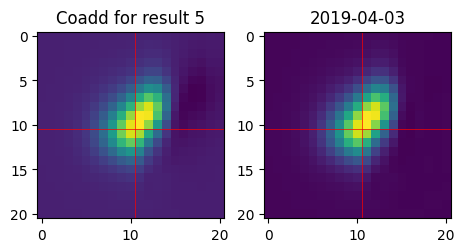

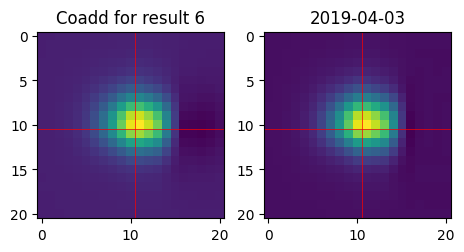

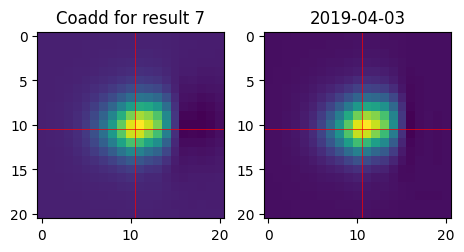

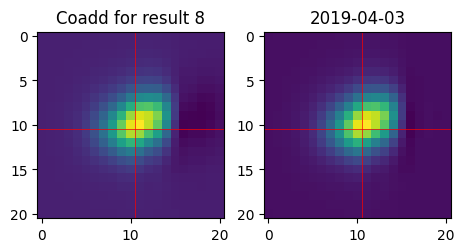

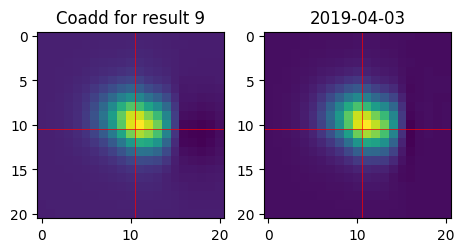

In [12]:
for i in range(min(len(results),10)):
    plot_daily_coadds(results, i)

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/kbmod/analysis/plotting.py:448: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(layout="constrained")


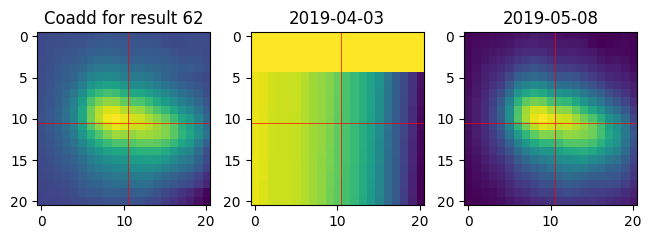

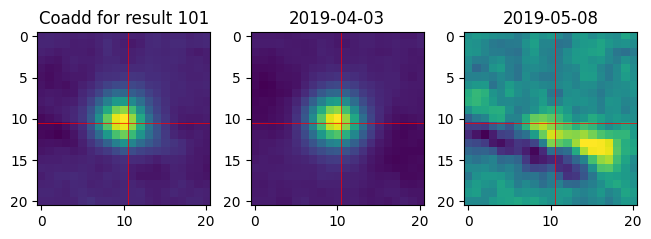

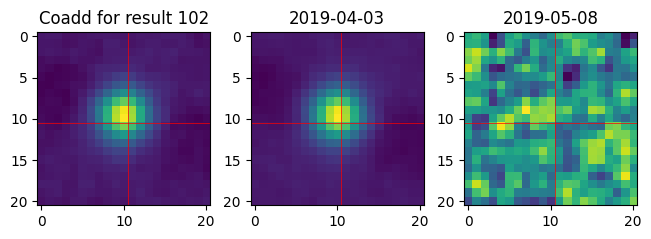

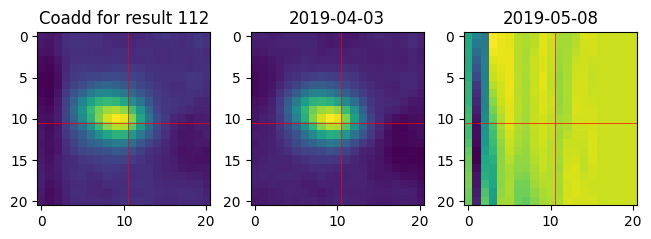

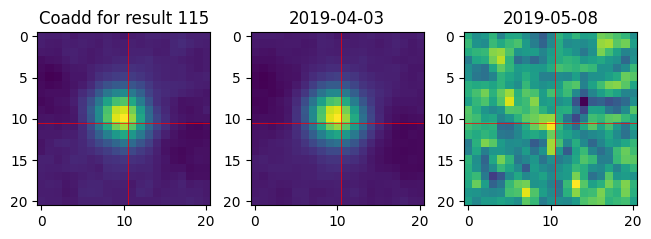

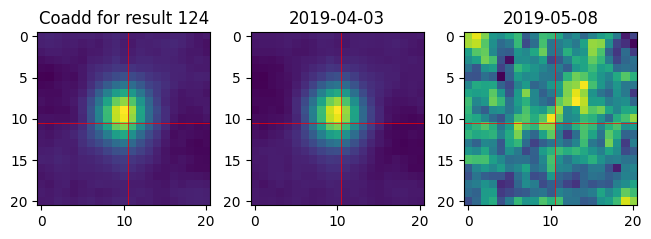

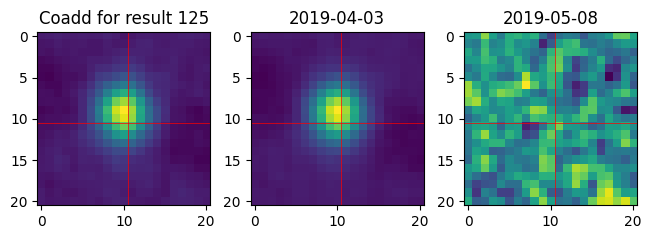

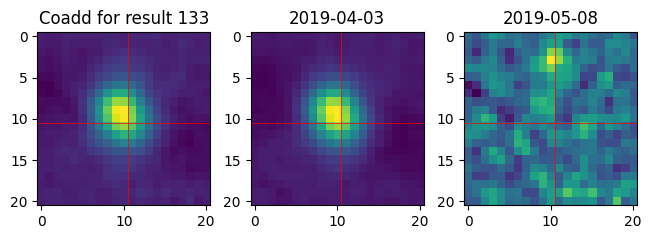

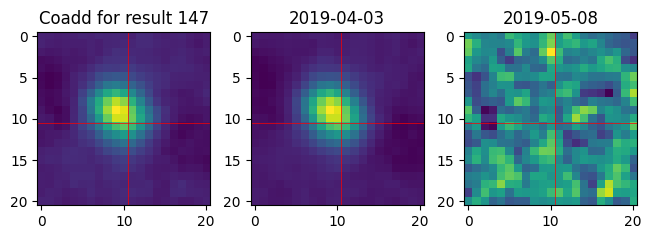

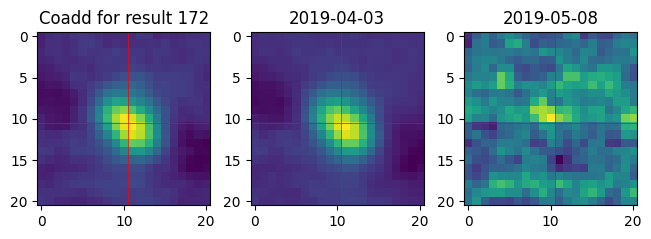

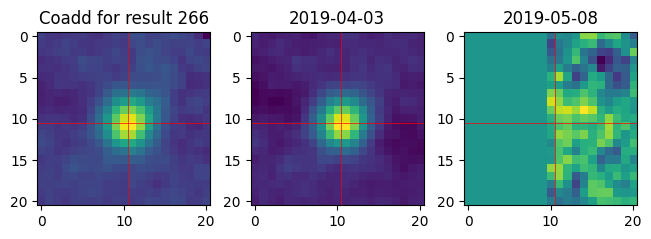

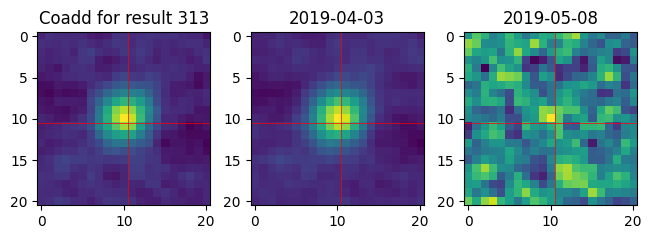

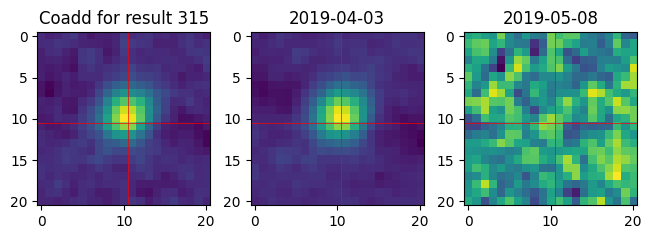

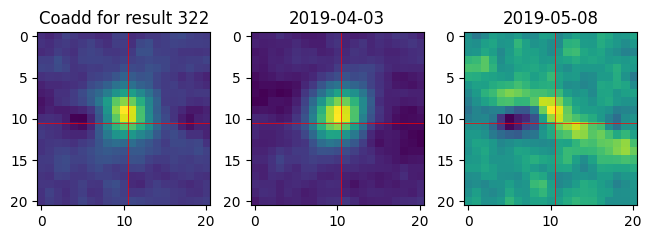

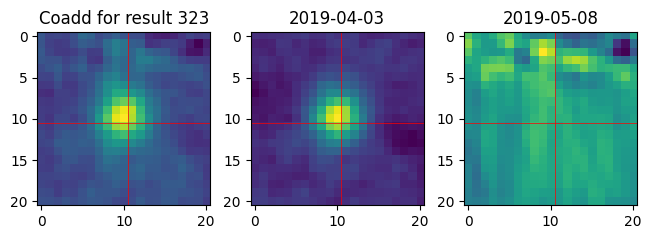

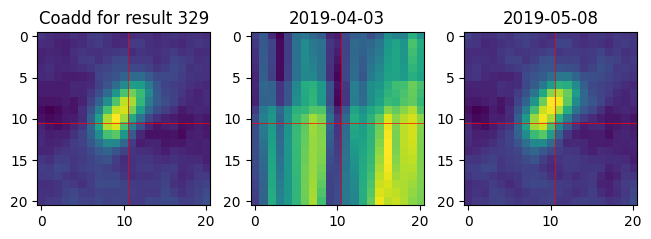

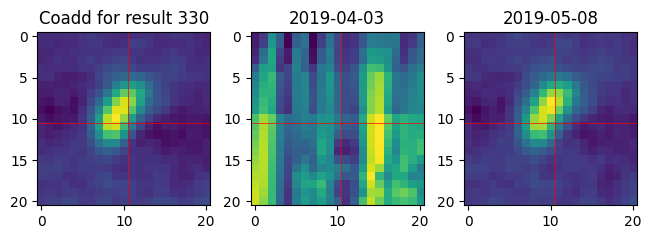

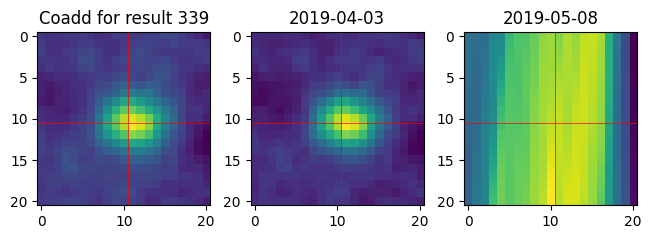

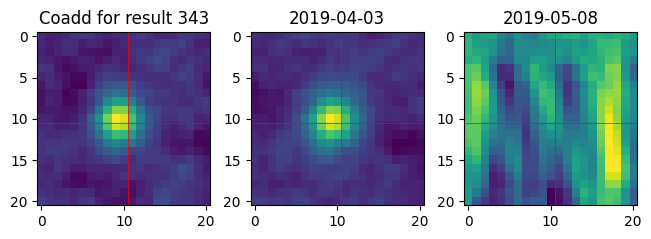

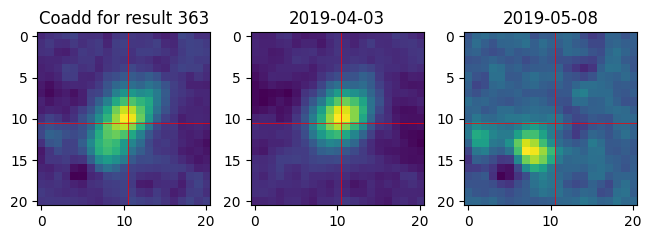

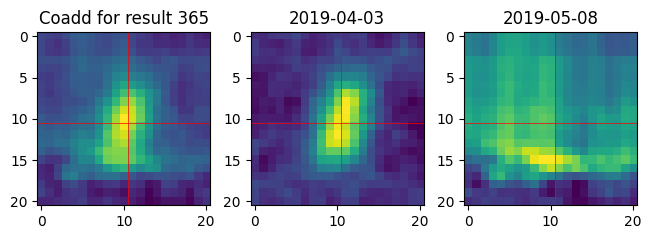

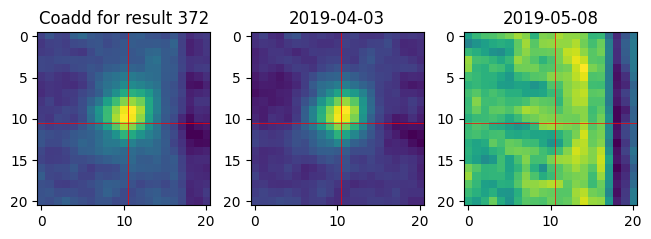

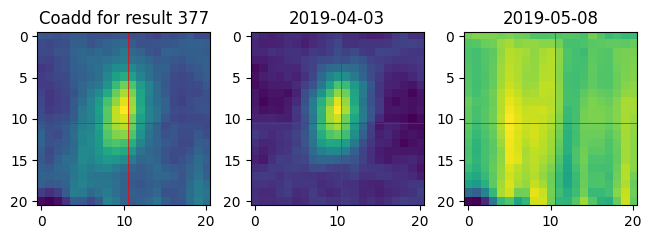

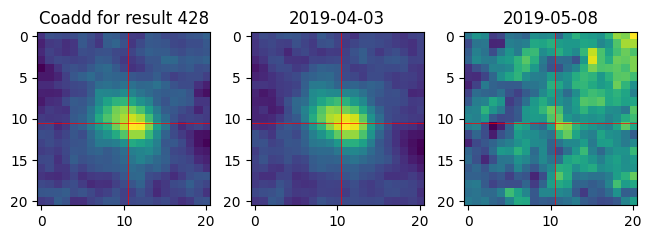

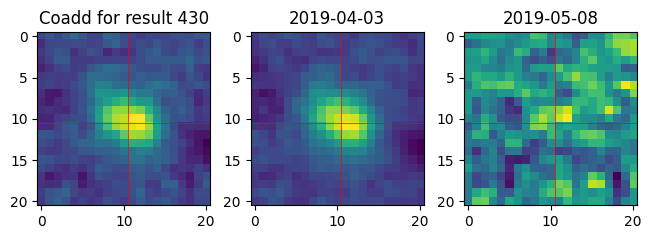

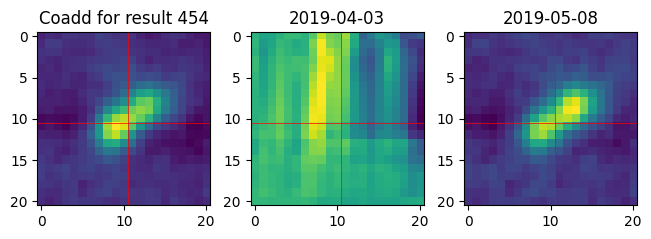

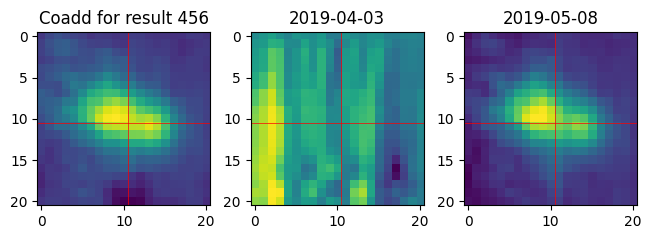

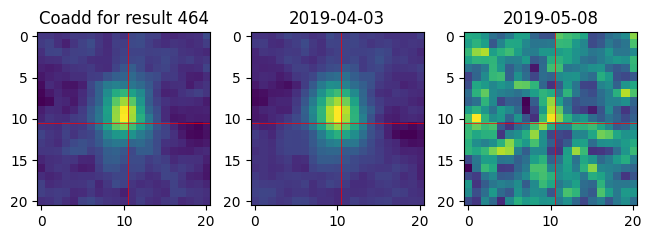

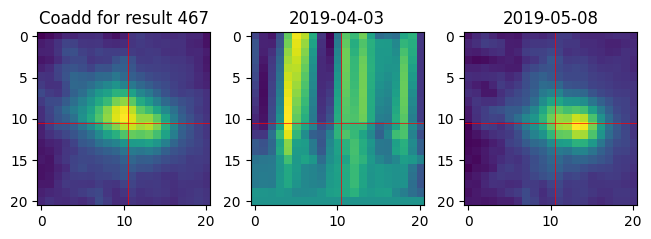

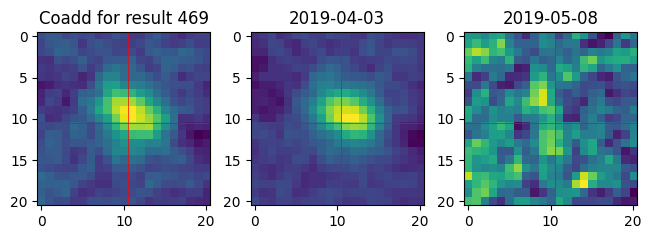

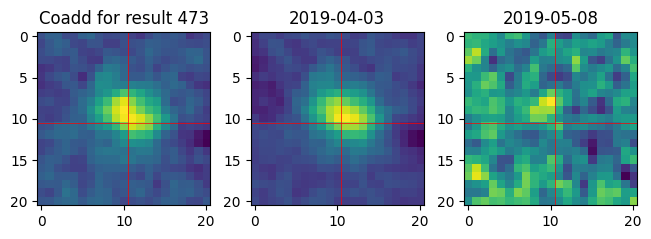

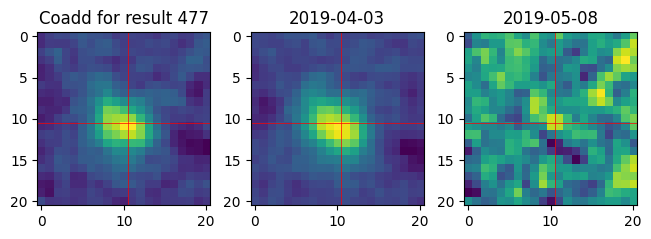

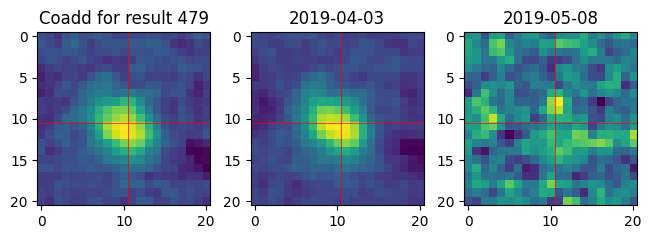

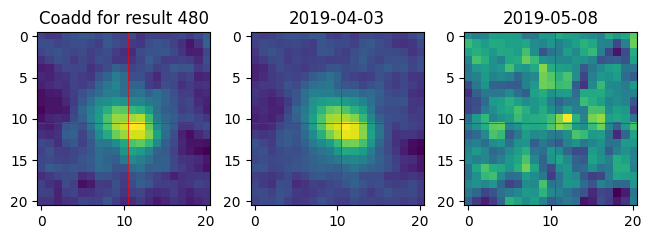

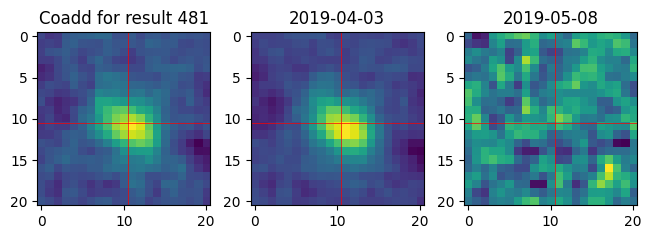

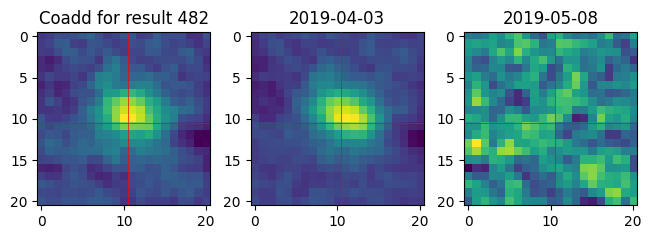

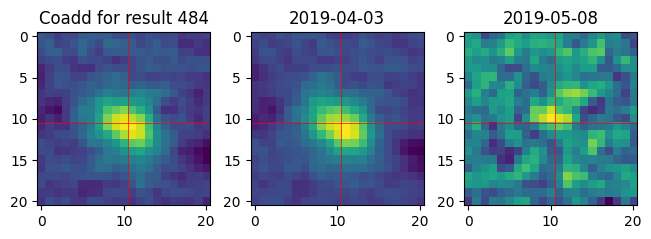

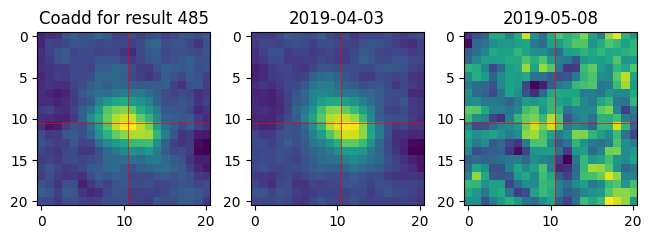

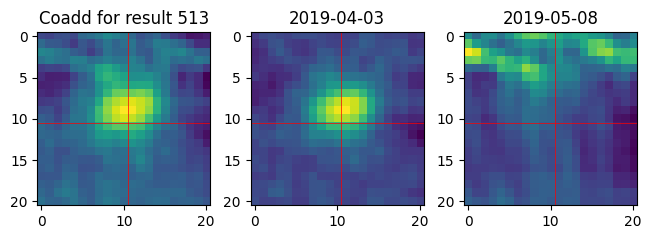

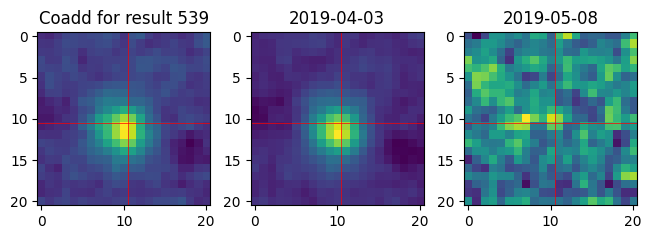

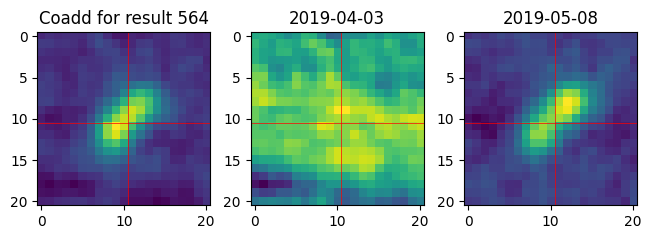

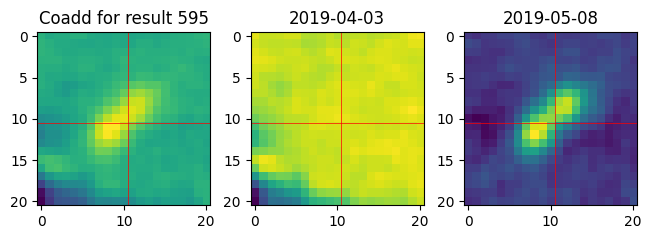

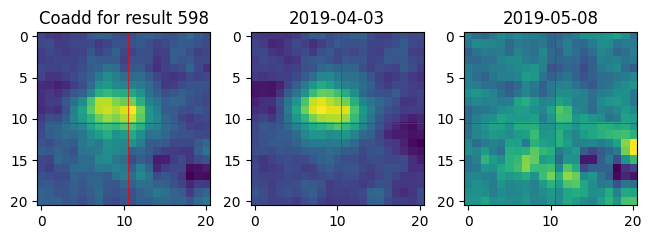

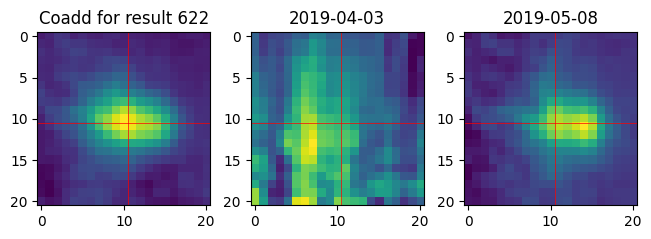

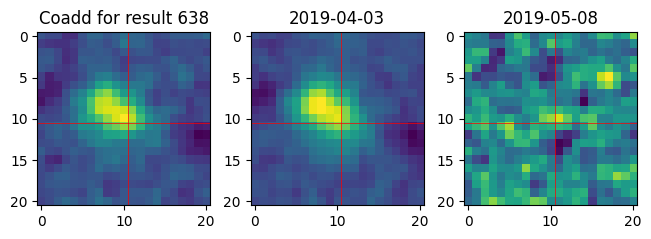

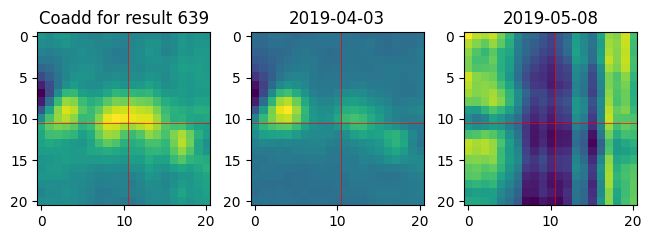

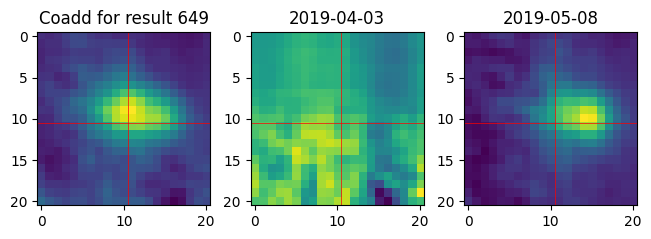

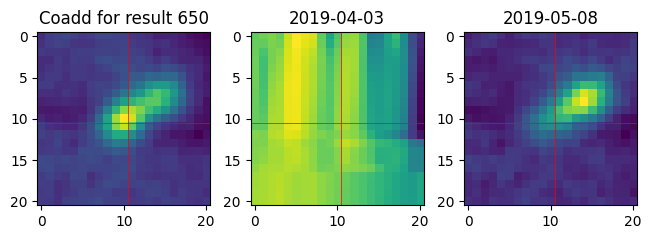

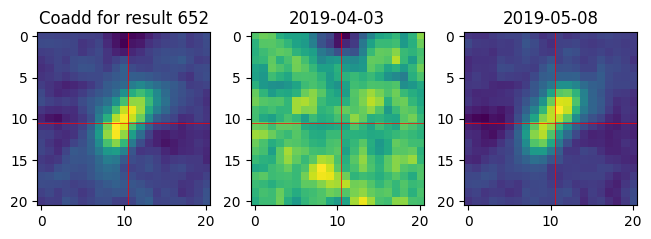

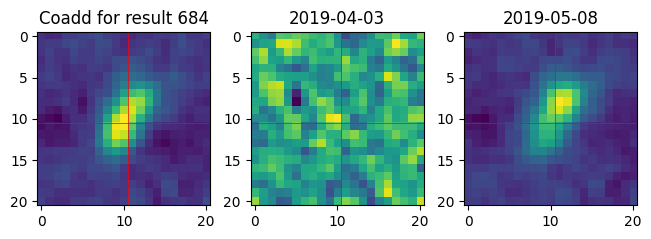

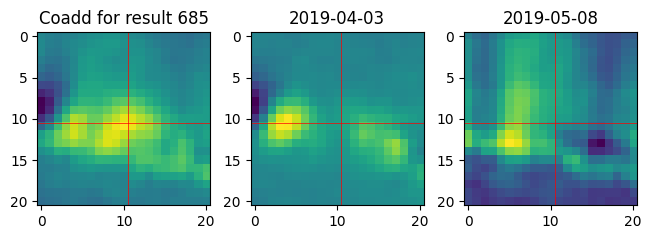

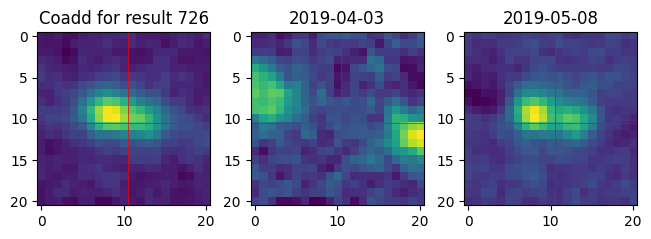

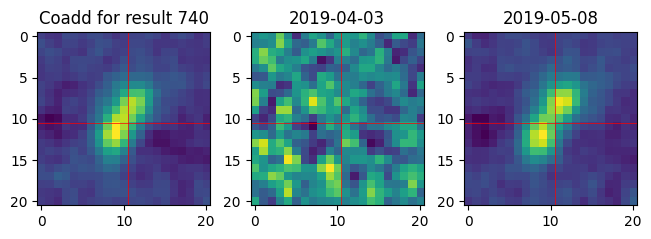

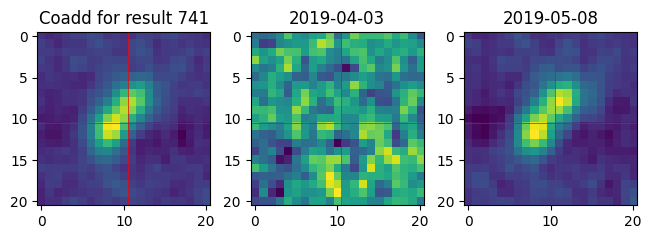

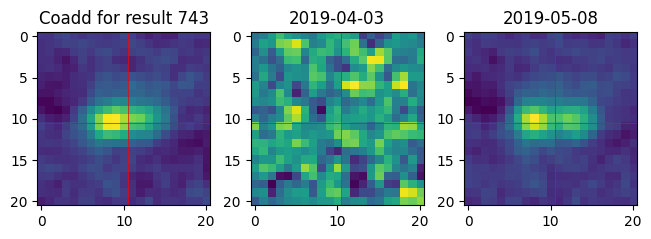

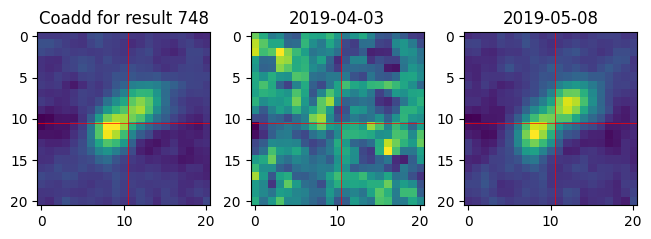

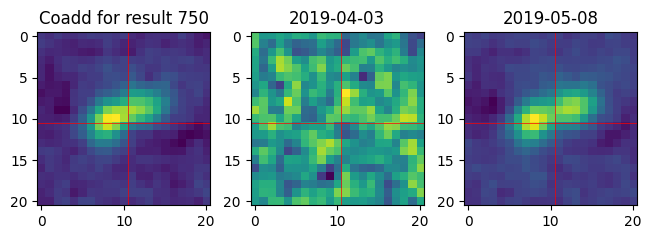

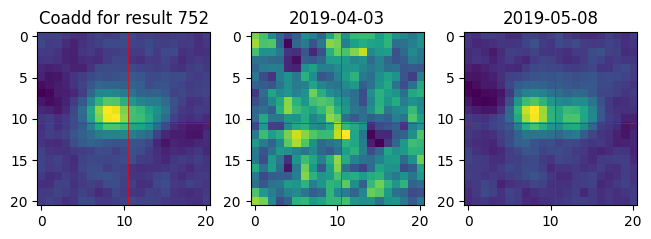

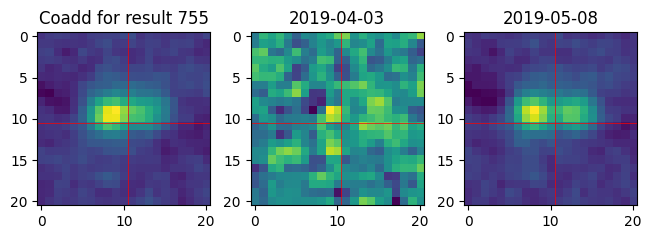

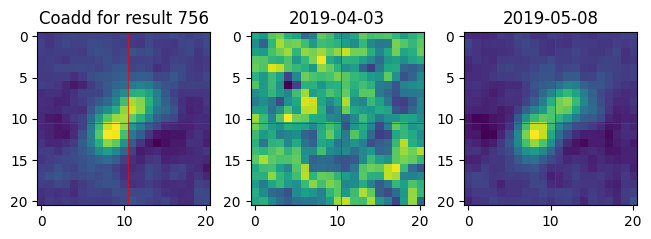

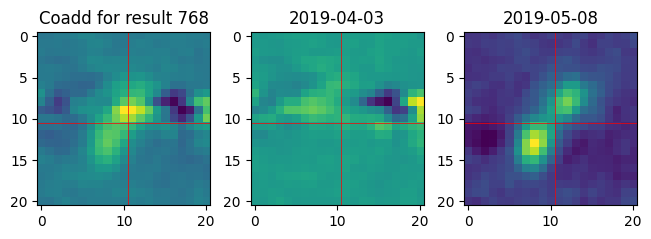

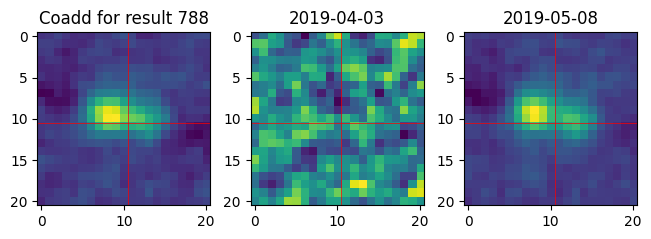

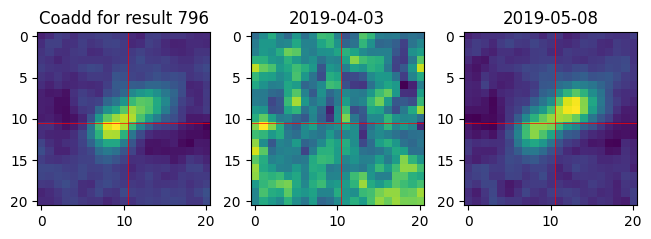

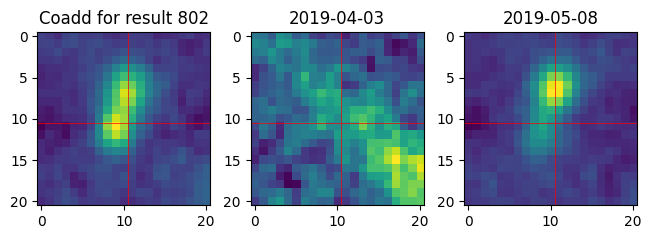

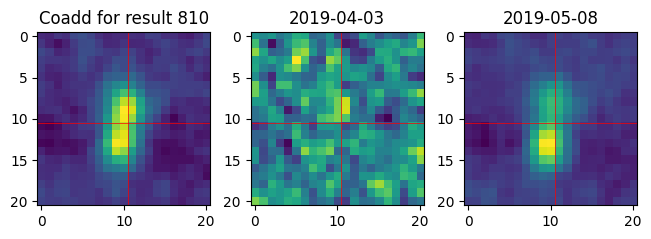

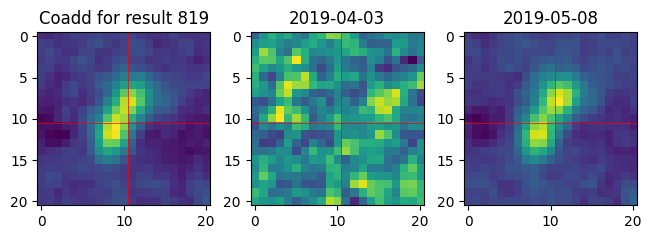

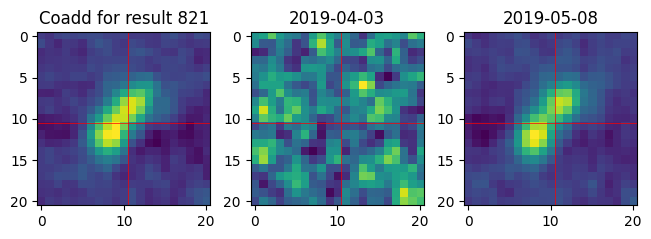

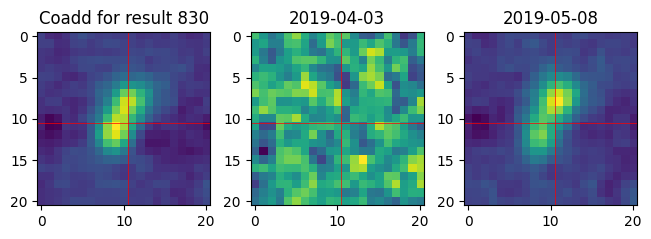

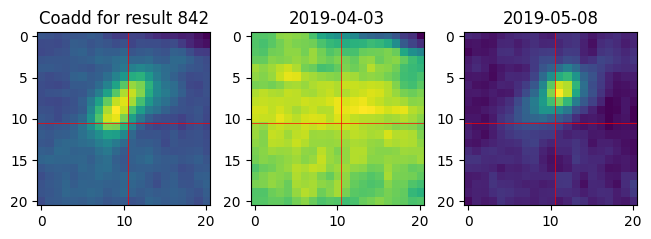

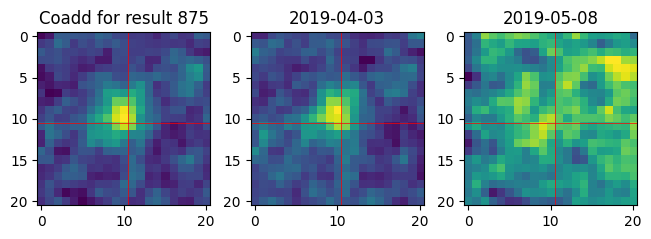

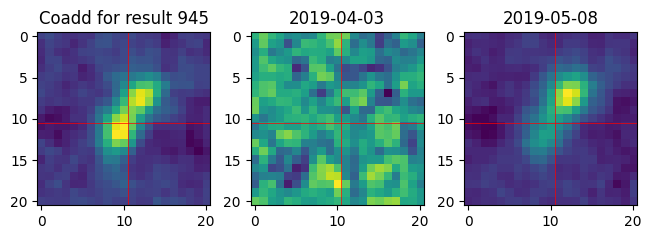

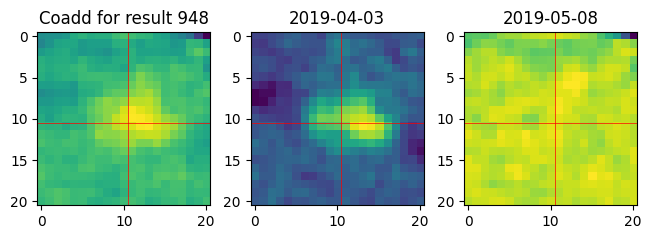

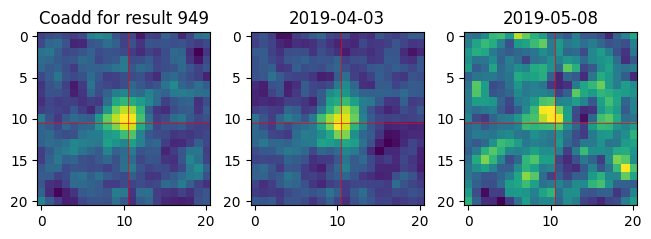

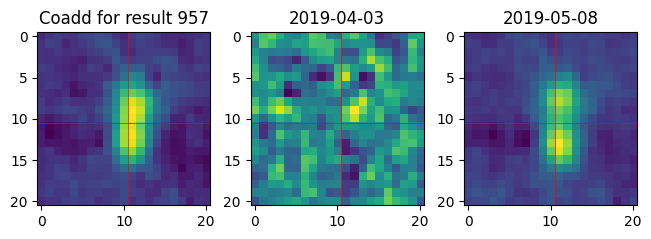

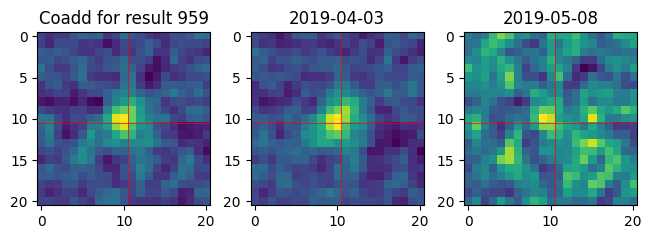

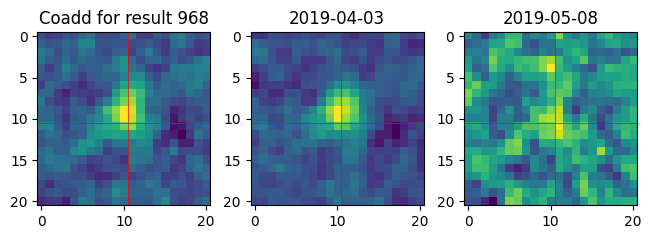

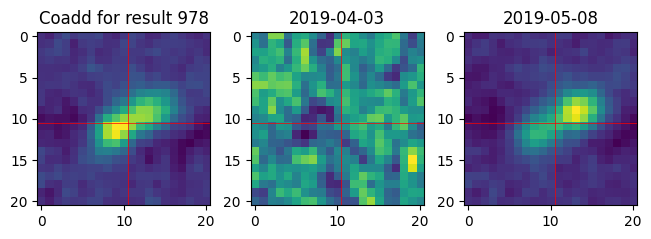

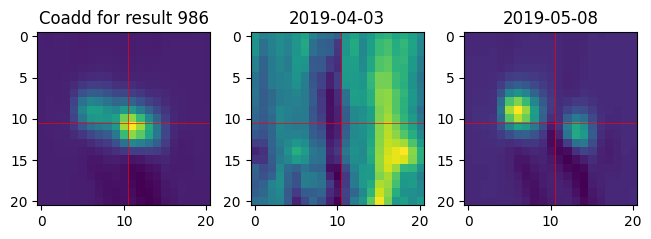

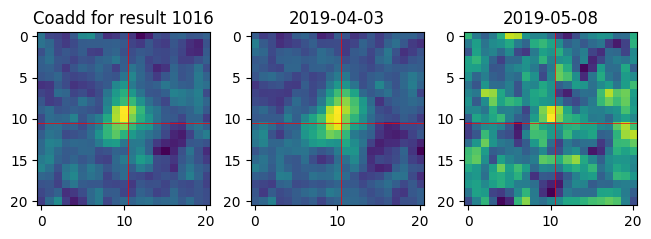

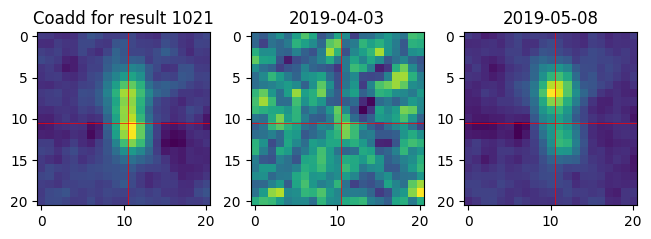

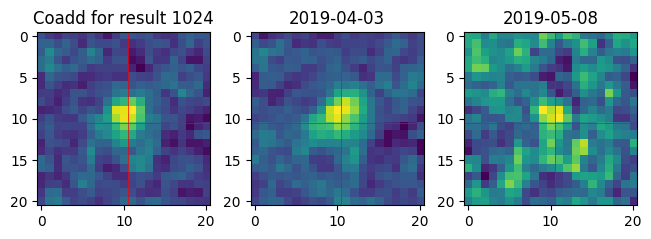

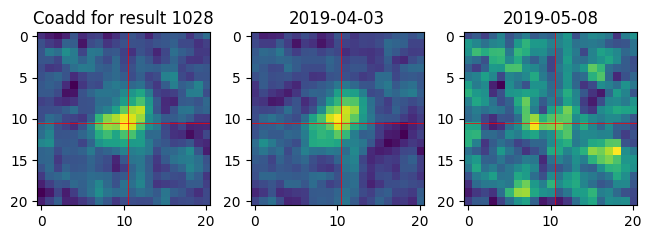

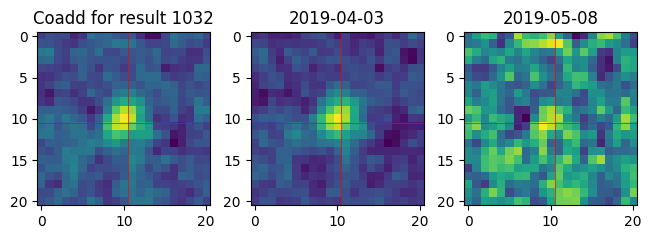

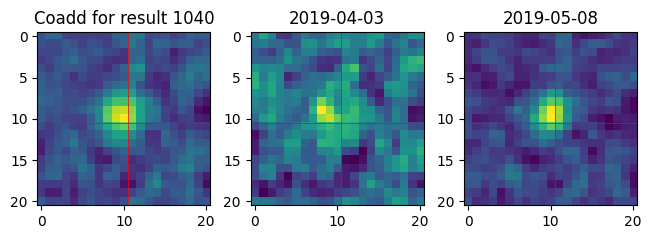

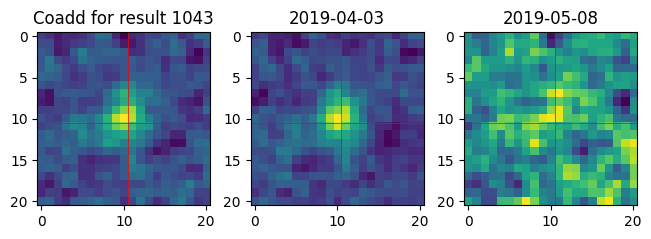

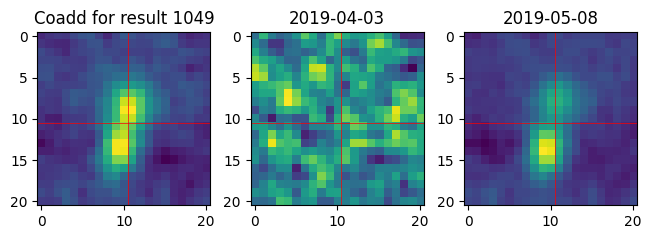

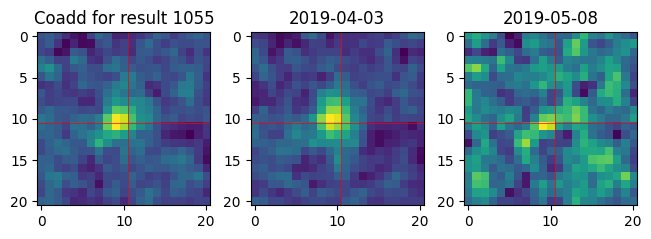

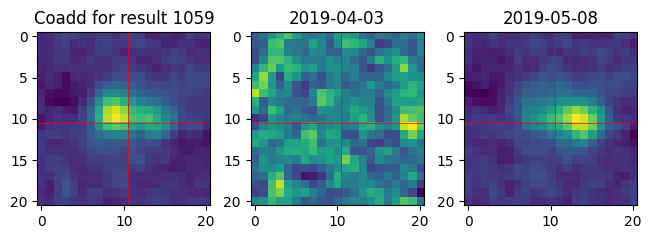

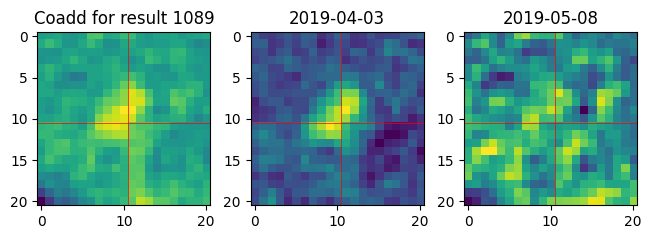

In [13]:
for i in range(len(results)):
    if results[i]["num_days"] >= 2:
        plot_daily_coadds(results, i)

# Search for results that are near known fakes

We have a table of fakes that are present in the data, uniquely identified by the 'ORBITID' column

In [14]:
fakes = Table.read(fakes_path, format="csv")
fakes.sort(["ORBITID", "mjd_mid"]) # Sort by the unique ORBITID for each fake and then observation time
fakes

<Table length=177367>
  col0  Unnamed: 0          RA         ...     fit_200.0      DEEP_id large_pile
 int64    int64          float64       ...      float64         str3     str5   
------- ---------- ------------------- ... ------------------ ------- ----------
    311        311  -143.9249546115954 ...  199.0948808939037     A0c      False
    312        312 -143.92497257438345 ... 199.09486793589687     A0c      False
    313        313 -143.92499046199325 ...  199.0948550339872     A0c      False
    314        314 -143.92690429747086 ... 199.09347983158304     A0c      False
    315        315  -143.9269221234081 ...  199.0934670217728     A0c      False
    316        316  -143.9269399228252 ... 199.09345423019795     A0c      False
   1210       1210 -144.01027992110355 ... 199.00688595239595     A0b       True
   1211       1211 -144.01031061347098 ... 199.00689020914297     A0b       True
   1212       1212 -144.01034147828395 ...  199.0068944901652     A0b       True
    ...        ...                 ... ...                ...     ...        ...
4665526    4665611  -144.4538513749503 ...  199.0917087217192     A0c      False
4665527    4665612 -144.45532757625452 ...  199.0903561240497     A0c      False
4665528    4665613 -144.45534132578513 ... 199.09034352531955     A0c      False
4665529    4665614 -144.45535505488442 ...   199.090330944532     A0c      False
4665728    4665813  -144.7507294271931 ... 199.01049318492448     A0a      False
4665729    4665814 -144.75074447654444 ... 199.01049796691063     A0a      False
4665730    4665815 -144.75075943919956 ... 199.01050272164164     A0a      False
4665731    4665816  -144.7521187831985 ...   199.010936827924     A0a      False
4665732    4665817 -144.75213373645173 ...  199.0109416382286     A0a      False
4665733    4665818  -144.7521488761642 ...  199.0109465095607     A0a      False

astropy allows us to take two catalogus of coordinates (represented by `SkyCoord` objects) and easily search for nearest neighbors between them. 

First, as a simple approximation let's translate the initial (x, y) of each of our results into an (ra, dec). Note that we are using a reflex-corrected WCS from our `WorkUnit` so the (ra, dec) will be in reflex-corrected space.

In [15]:
def get_ra_decs_from_trj(idx, result_table, trajectories):
    # To generate a trajectory object we need times of each valid observation for this result
    is_valid = result_table[idx]["obs_valid"]
    valid_obstimes = []
    for i in range(len(is_valid)):
        if is_valid[i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    # Now we can generate (ra, DEC) coordinates for the trajectory using our work unit's WCS
    return trajectory_predict_skypos(trajectories[idx], wu.wcs, valid_obstimes)

ra_decs = [get_ra_decs_from_trj(i, results, trajectories) for i in range(len(results))]

results.table["ra_dec_start"] = [ra_decs[i][0] for i in range(len(results))]
results.table["ra_dec_end"] = [ra_decs[i][-1] for i in range(len(results))]

In [16]:
fakes_guess_ra = "RA_42.0"
fakes_guess_dec = "Dec_42.0"

Now we can translate our (ra, dec) pairs into single `SkyCoord` objects.

Then we can use astopy's `search_around_sky` to find which KBMOD results are near our known fakes, with a max separation limit of 1 arcsecond

In [17]:
# Get the reflex-corrected (ra, DEC) positions for our fakes  
fake_coords = SkyCoord(ra=fakes[fakes_guess_ra] * u.degree, dec=fakes[fakes_guess_dec] * u.degree)

# Performe the search for if our trajectory start positions were near any fakes
idx1, idx2, sep2dAngle, dist3d = search_around_sky(results["ra_dec_start"], fake_coords, 1 * u.arcsecond)

`idx1` Maps fakes to their nearest neighbors in the results. Each value is an index to a potential finding within our results table.

In [18]:
print(len(idx1))
idx1

2304


array([  24,   24,   24, ..., 1073, 1073, 1073])

In [19]:
idx2

array([ 81695,  81696,  81697, ..., 166870, 166871, 166872])

In [20]:
potential_fake_starts = np.unique(idx1)
potential_fake_starts

array([  24,   25,   27,   28,   60,   81,   84,   97,  101,  102,  106,
        112,  115,  123,  124,  125,  133,  143,  147,  172,  323,  325,
        342,  343,  349,  372,  373,  374,  428,  429,  430,  450,  460,
        464,  469,  473,  477,  479,  480,  481,  482,  484,  485,  513,
        539,  598,  623,  645,  783,  800,  841,  853,  876,  942,  948,
        960,  990, 1033, 1052, 1064, 1073])

Let's first examine the first result which we believe might be a fake.

In [21]:
results[potential_fake_starts[0]]

<Row index=24>
  x     y            vx               vy          likelihood            flux        obs_count         psi_curve                  phi_curve             obs_valid            stamp                                                        all_stamps                                              num_days              ra_dec_start                            ra_dec_end              
                                                                                                                                                                                                                                                                                                                         deg,deg                                deg,deg                
int64 int64       float64          float64         float64            float64         int64          float64[189]               float64[189]           bool[189]        float32[21,21]                                                  object[189]                                               int64                  SkyCoord                               SkyCoord               
----- ----- ------------------- ------------- ------------------ ------------------ --------- ------------------------- ---------------------------- ------------- ------------------------ ---------------------------------------------------------------------------------------------------- -------- -------------------------------------- --------------------------------------
 2285  3137 -100.61772918701172 -50.982421875 508.62250917656684 2429.6648515775964       101 1.1711266040802002 .. 0.0 0.0004483153752516955 .. 0.0 True .. False -143.75073 .. -123.85597 <kbmod.search.RawImage object at 0x7fb9ce4d0db0> .. <kbmod.search.RawImage object at 0x7fb9ce4d3b70>        1 215.83299485424251,-13.770761274644213 215.83432516787806,-13.771415958040404

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


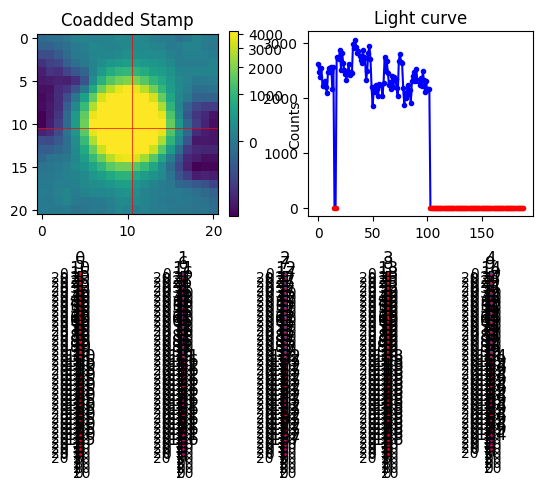

In [22]:
# helper function to plot a row of the results table
plot_result_row(results[potential_fake_starts[0]])

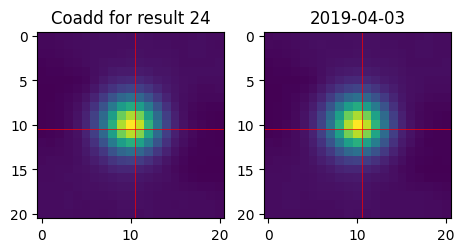

In [23]:
plot_daily_coadds(results, potential_fake_starts[0])

`idx2` shows the inverse mapping of which fakes might be potential results. Here its values are indices within our fakes table.

So taking the first potential match we examined above, we can use the corresponding index (in this case 0) to inspect within our fakes table.


In [24]:
fakes[idx2[0]]["ORBITID"]

2959075

In [25]:
def find_fakes_matches(fakes_table, idx1, idx2):
    # Matches a result's index index in the results table to its corresponding fake orbit ID
    matches = {}
    for i in range(len(idx1)):
        if idx1[i] not in matches:
            matches[idx1[i]] = set()
        matches[idx1[i]].add(fakes[idx2[i]]["ORBITID"])
        
    return matches
    
result_start_to_fakes = find_fakes_matches(fakes, idx1, idx2)
result_start_to_fakes
    

{24: {2959075},
 25: {2959075},
 27: {2959075},
 28: {2959075},
 60: {4579118},
 81: {4579118},
 84: {80829},
 97: {51927},
 101: {51927},
 102: {51927},
 106: {51927},
 112: {51927},
 115: {51927},
 123: {51927},
 124: {51927},
 125: {51927},
 133: {51927},
 143: {51927},
 147: {51927},
 172: {80829},
 323: {3670663},
 325: {3670663},
 342: {3670663},
 343: {3670663},
 349: {3670663},
 372: {3670663},
 373: {5056833},
 374: {3670663},
 428: {3670663},
 429: {1438988},
 430: {3670663},
 450: {3670663},
 460: {3670663},
 464: {3670663},
 469: {3670663},
 473: {3670663},
 477: {3670663},
 479: {3670663},
 480: {3670663},
 481: {3670663},
 482: {3670663},
 484: {3670663},
 485: {3670663},
 513: {3670663},
 539: {3670663},
 598: {3670663},
 623: {3407909},
 645: {3407909},
 783: {762267},
 800: {5993946},
 841: {1546663},
 853: {1546663},
 876: {6352390},
 942: {2128940},
 948: {1438988},
 960: {2128940},
 990: {762267},
 1033: {5993946},
 1052: {2128940},
 1064: {762267},
 1073: {5993946}

In [26]:
fakes[fakes["ORBITID"] == 4661373]

<Table length=189>
  col0  Unnamed: 0          RA         ...     fit_200.0      DEEP_id large_pile
 int64    int64          float64       ...      float64         str3     str5   
------- ---------- ------------------- ... ------------------ ------- ----------
3544146    3544146 -143.97072557018188 ... 199.09966130841207     A0b       True
3544147    3544147 -143.97074789276712 ... 199.09964813185425     A0b       True
3544148    3544148 -143.97077023693987 ... 199.09963494429823     A0b       True
3544149    3544149 -143.97079254185326 ... 199.09962178162576     A0b       True
3544150    3544150 -143.97081496949383 ... 199.09960854823183     A0b       True
3544151    3544151 -143.97083731356403 ...  199.0995953658203     A0b       True
3544152    3544152  -143.9708596111357 ... 199.09958221247928     A0b       True
3544153    3544153 -143.97088210665507 ...  199.0995689439995     A0b       True
3544154    3544154 -143.97090444973378 ...  199.0995557670314     A0b       True
    ...        ...                 ... ...                ...     ...        ...
3544349    3544349 -144.46026036085755 ...   199.007193792322     A0b       True
3544350    3544350 -144.46028531127718 ...  199.0071981792608     A0b       True
3544351    3544351 -144.46031029461403 ...  199.0072025729513     A0b       True
3544352    3544352 -144.46033510371794 ... 199.00720693696127     A0b       True
3544353    3544353 -144.46035987694162 ...  199.0072112956246     A0b       True
3544354    3544354  -144.4603847649822 ... 199.00721567546748     A0b       True
3544355    3544355 -144.46040974556576 ...    199.00722007259     A0b       True
3544356    3544356  -144.4604346531962 ... 199.00722445787216     A0b       True
3544357    3544357 -144.46045968620024 ...  199.0072288662407     A0b       True
3544358    3544358 -144.46048448806897 ... 199.00723323491795     A0b       True

# Now see if the end points of any of the trajectories are also near the endpoints of our fakes

In [27]:
idx1_end, idx2_end, sep2dAngle_end, dist3d_end = search_around_sky(results["ra_dec_end"], fake_coords, 1 * u.arcsecond)

In [28]:
idx1_end

array([  24,   24,   24, ..., 1073, 1073, 1073])

In [29]:
idx2_end

array([ 81778,  81779,  81780, ..., 166959, 166960, 166961])

In [30]:
potential_fake_ends = np.unique(idx1_end)
potential_fake_ends

array([  24,   25,   27,   28,   60,   81,   84,   97,  106,  325,  329,
        330,  342,  349,  373,  374,  429,  450,  454,  460,  564,  595,
        623,  645,  650,  652,  684,  726,  741,  743,  748,  750,  752,
        755,  756,  783,  788,  796,  800,  802,  830,  841,  842,  853,
        942,  945,  954,  960,  978,  990, 1021, 1033, 1040, 1052, 1059,
       1064, 1073])

In [31]:
result_end_to_fakes = find_fakes_matches(fakes, idx1_end, idx2_end)
result_end_to_fakes

{24: {2959075},
 25: {2959075},
 27: {2959075},
 28: {2959075},
 60: {4579118},
 81: {4579118},
 84: {80829},
 97: {51927},
 106: {51927},
 325: {3670663},
 329: {51927},
 330: {51927},
 342: {3670663},
 349: {3670663},
 373: {5056833},
 374: {3670663},
 429: {1438988},
 450: {3670663},
 454: {51927},
 460: {3670663},
 564: {51927},
 595: {51927},
 623: {3407909},
 645: {3407909},
 650: {51927},
 652: {51927},
 684: {51927},
 726: {51927},
 741: {51927},
 743: {51927},
 748: {51927},
 750: {51927},
 752: {51927},
 755: {51927},
 756: {51927},
 783: {762267},
 788: {51927},
 796: {51927},
 800: {5993946},
 802: {51927},
 830: {51927},
 841: {1546663},
 842: {51927},
 853: {1546663},
 942: {2128940},
 945: {51927},
 954: {5056833},
 960: {2128940},
 978: {51927},
 990: {762267},
 1021: {51927},
 1033: {5993946},
 1040: {3163825},
 1052: {2128940},
 1059: {51927},
 1064: {762267},
 1073: {5993946}}

# Look for Fakes Matching Both the Start and Endpoint

In [32]:
# Maps of result indices that could be matched to a fake for both their start and end coordinate
result_full_fake_match = {}
for r in result_start_to_fakes:
    # Check for results that also were matched to a fake for their end coordinate
    if r in result_end_to_fakes:
        shared_fakes = result_start_to_fakes[r].intersection(result_end_to_fakes[r])
        if len(shared_fakes) > 0:
            result_full_fake_match[r] = shared_fakes
result_full_fake_match

{24: {2959075},
 25: {2959075},
 27: {2959075},
 28: {2959075},
 60: {4579118},
 81: {4579118},
 84: {80829},
 97: {51927},
 106: {51927},
 325: {3670663},
 342: {3670663},
 349: {3670663},
 373: {5056833},
 374: {3670663},
 429: {1438988},
 450: {3670663},
 460: {3670663},
 623: {3407909},
 645: {3407909},
 783: {762267},
 800: {5993946},
 841: {1546663},
 853: {1546663},
 942: {2128940},
 960: {2128940},
 990: {762267},
 1033: {5993946},
 1052: {2128940},
 1064: {762267},
 1073: {5993946}}

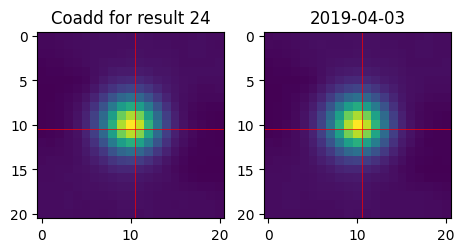

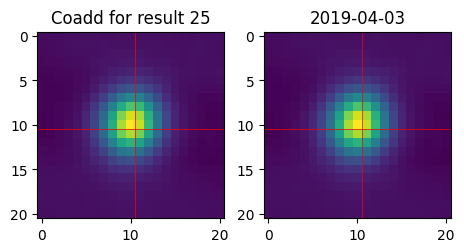

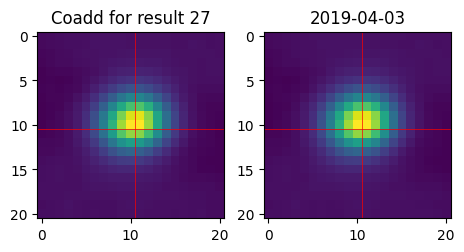

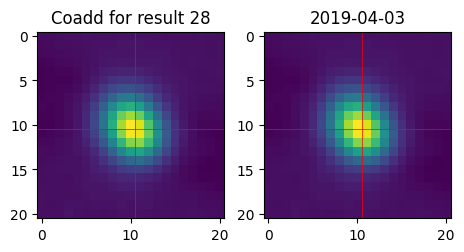

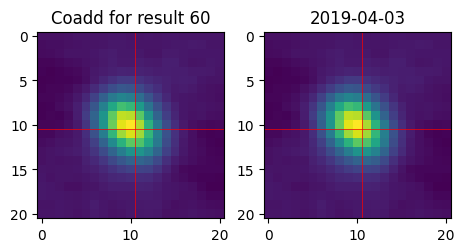

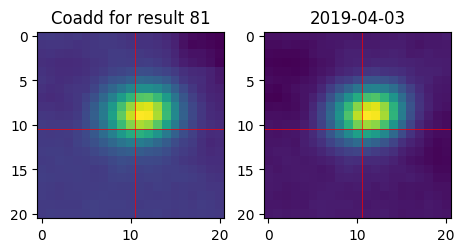

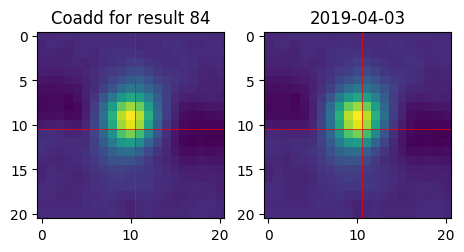

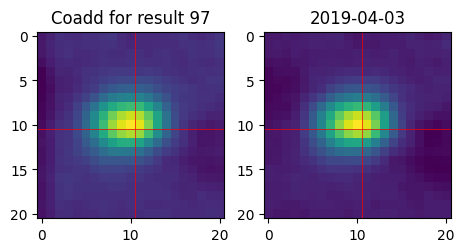

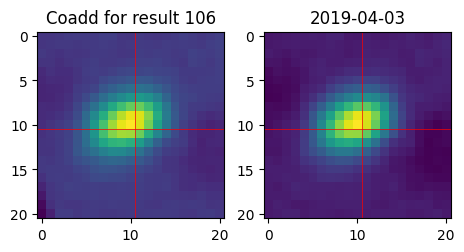

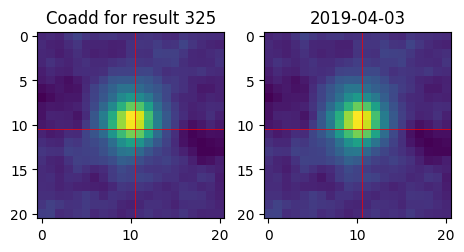

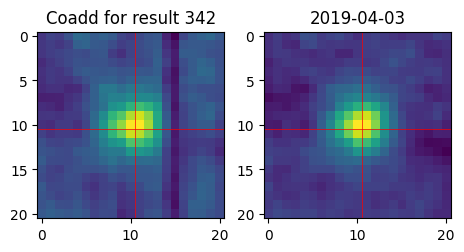

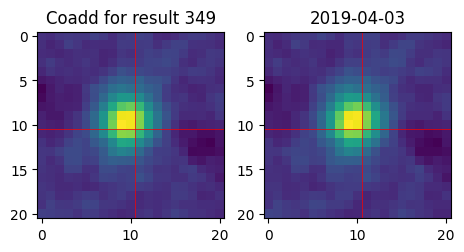

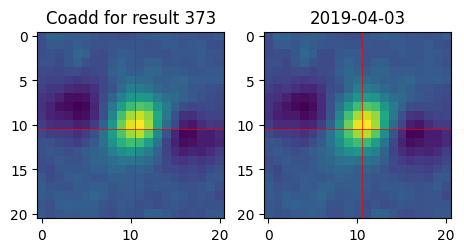

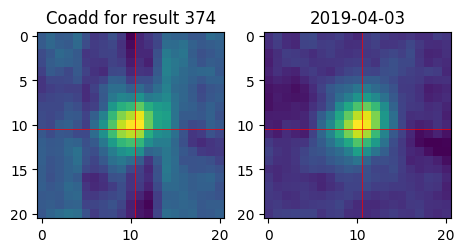

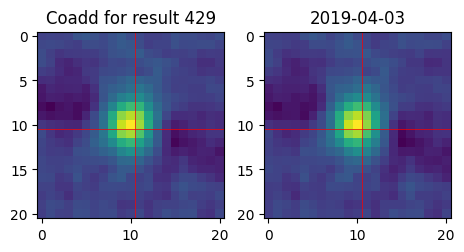

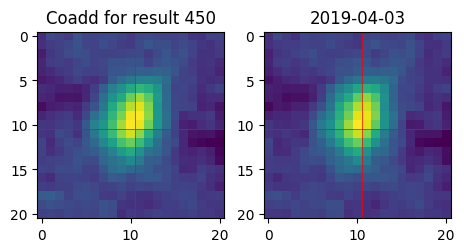

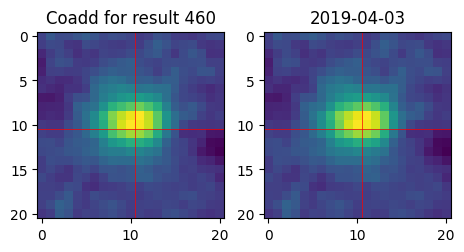

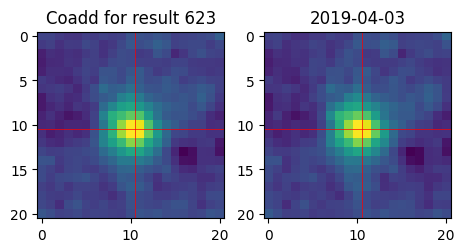

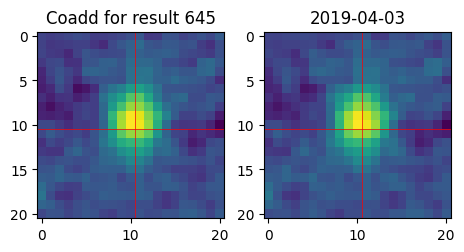

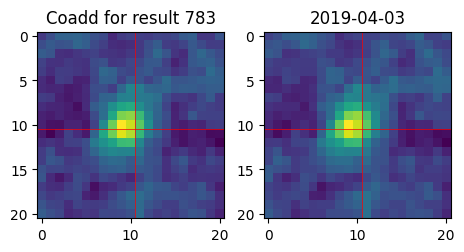

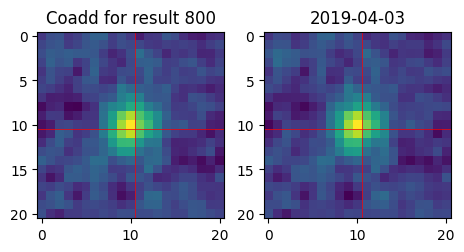

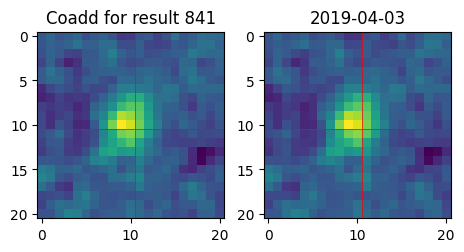

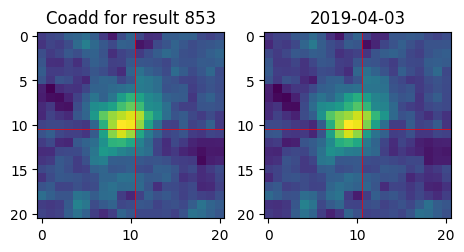

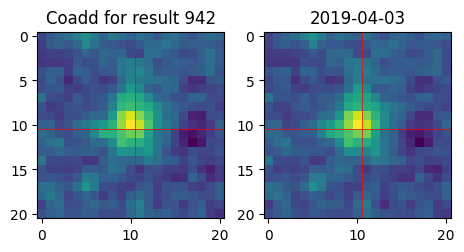

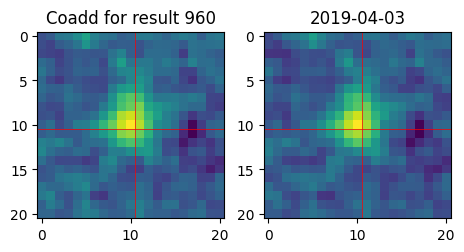

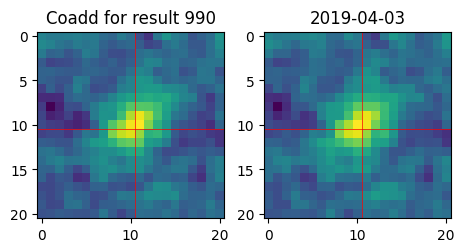

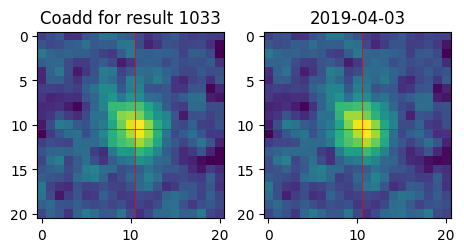

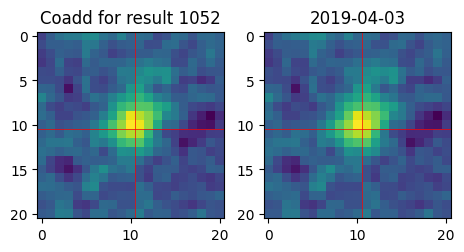

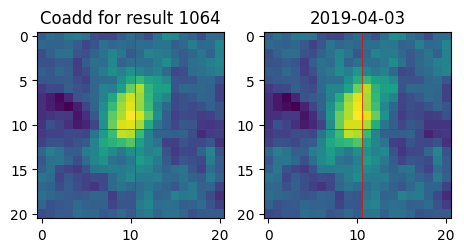

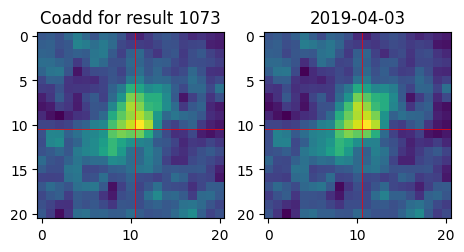

In [33]:
for idx in result_full_fake_match:
    plot_daily_coadds(results, idx)

Result 6 is interesting, so let's examine its matching fake(s)

In [ ]:
result_full_fake_match[6]

# Examine a given Fake

Let's evaluate the linearity and velocities of our fake

In [ ]:
CURR_ORBIT_ID = 3466970

In [ ]:
def evaluate_fake(fake_table, fake_orbit_id, verbose=True):
    our_fake = fake_table[fake_table["ORBITID"] == fake_orbit_id]

    our_fake.sort("mjd_mid")
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))

    A = np.vstack([fake_x, np.ones(len(fake_x))]).T
    m, c = np.linalg.lstsq(A, fake_y, rcond=None)[0]

    # Make predictions
    y_pred = m * fake_x + c

    # Compute R-squared
    ss_res = np.sum((fake_y - y_pred) ** 2)
    ss_tot = np.sum((fake_y - np.mean(fake_y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    elapsed_time = our_fake["mjd_mid"][-1] - our_fake["mjd_mid"][0]
    fake_vx = float(fake_x[-1] - fake_x[0]) / elapsed_time
    fake_vy = float(fake_y[-1] - fake_y[0]) / elapsed_time
    fake_v = math.sqrt(fake_vx*fake_vx + fake_vy*fake_vy)

    print(f'For fake ORBITID={fake_orbit_id}, R^2={r_squared} and its pixel/day velocities are vx={fake_vx} vy={fake_vy}, v={fake_v}')
    return r_squared, fake_vx, fake_vy, fake_v
    

evaluate_fake(fakes, CURR_ORBIT_ID)

# Plot Fake by Day
Here we align 

In [36]:
def manual_coadd(stamps, stamp_indices, plot_me=False):
    # Manually coadds stamps at a given set of indices in the image stack
    result_stamp = stamps[stamp_indices[0]].image.copy()
    for i in stamp_indices[1:]:
        result_stamp += stamps[i].image
    if plot_me:
        plt.imshow(result_stamp, cmap='grey')
    return result_stamp

def plot_daily_fake_stamps(stack, fakes_table, fake_orbit_id):
    # Pull the sorted fakes table
    our_fake = fakes_table[fakes_table["ORBITID"] == fake_orbit_id]
    our_fake.sort("mjd_mid")
    
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    imgs = stack.get_images()
    
    stack_obstimes = [imgs[i].get_obstime() for i in range(len(imgs))]
    fake_times = our_fake["mjd_mid"]

    # Match to the closest times
    # 
    epsilon = 0.01
    closest_times = [-1 for i in fake_times] # List indices in the image stack with the closest obstime to our fake time
    for i in range(len(fake_times)):
        curr_fake_time = fake_times[i]
        for j in range(len(stack_obstimes)):
            old_closest_time = stack_obstimes[closest_times[i]]
            curr_time = stack_obstimes[j]
            curr_diff = abs(curr_time - curr_fake_time)
            if curr_diff <= epsilon:
                if closest_times[i] == -1 or curr_diff < abs(old_closest_time - curr_fake_time):
                    closest_times[i] = j
    
    # Generate fake_stamps
    fake_stamps = []
    for i in range(len(closest_times)):
        if closest_times[i] != -1:
            curr_img = imgs[closest_times[i]].get_science()
            fake_stamps.append(curr_img.create_stamp(fake_x[i], fake_y[i], 10, False))
    
    # Plot the coadds for the whole and all days
    img_to_plot = [manual_coadd(fake_stamps, range(len(fake_stamps)), plot_me=False)]
    labels = [f'ORBITID={fake_orbit_id}']
    for day in set([int(x) for x in fake_times]):
        current_idx = []
        for i in range(len(closest_times)):
            if int(imgs[closest_times[i]].get_obstime()) == day: #fake_times[i] == day:
                current_idx.append(i)
        img_to_plot.append(manual_coadd(fake_stamps, current_idx, plot_me=False))
        labels.append(str(day))
    plot_multiple_images(img_to_plot, labels=labels) 

plot_daily_fake_stamps(stack, fakes, CURR_ORBIT_ID)

NameError: name 'CURR_ORBIT_ID' is not defined

# Plot a Given KBMOD Result Trajectory Alongside a Given Fake

In the next cell we provide a variety of helper functions for evaluating a KBMOD trajectory alongside a given fake

In [37]:
def get_x_y_from_trj(idx, result_table, trajectories, times):
    dt = np.array(times)
    dt -= dt[0]

    trj = trajectories[idx]
    # Predict locations in pixel space.
    x_vals = trj.x + trj.vx * dt
    y_vals = trj.y + trj.vy * dt

    return x_vals, y_vals

def plot_res_traj(result_table, res_idx, trajectories):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    res_x, res_y = get_x_y_from_trj(res_idx, result_table, trajectories, valid_obstimes)
    
    min_date = min(valid_obstimes)
    max_date = max(valid_obstimes)
    day_sep = int(max_date) - int(min_date)

    kbmod_plt = plt.scatter(res_x, res_y, color='blue', label="KBMOD trajectory", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'KBMOD Result Trajectory {res_idx} ({day_sep} day separation)')
    plt.show()

def plot_fake(fake_table, orbit_id):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.show()
    
def plot_fake_ra_dec(fake_table, orbit_id):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    #fake_x, fake_y = SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree)
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(our_fake[fakes_guess_ra], our_fake[fakes_guess_dec], color='red', label="fakes", marker='.')
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.show()
    
def plot_fake_ra_dec_single_night(fake_table, orbit_id, night):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    our_fake =  our_fake[our_fake["local_obsnight"] == night]
    #fake_x, fake_y = SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree)
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(our_fake[fakes_guess_ra], our_fake[fakes_guess_dec], color='red', label="fakes", marker='.')
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({night})')
    plt.show()
    
def plot_fake_x_y_single_night(fake_table, orbit_id, night):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    our_fake =  our_fake[our_fake["local_obsnight"] == night]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({night})')
    plt.show()
    
    
def plot_res_traj_and_fake(result_table, res_idx, trajectories, fake_table, orbit_id):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    res_x, res_y = get_x_y_from_trj(res_idx, result_table, trajectories, valid_obstimes)
    
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(min(valid_obstimes), min(our_fake["mjd_mid"]))
    max_date = max(max(valid_obstimes), max(our_fake["mjd_mid"]))
    day_sep = int(max_date) - int(min_date)

    kbmod_plt = plt.scatter(res_x, res_y, color='blue', label="KBMOD trajectory", marker='|',  alpha=0.5)
    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='_',  alpha=0.5)
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'KBMOD Result Trajectory {res_idx} vs Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.legend((kbmod_plt, fake_plt), ("KBMOD trajectory", "fake"))
    plt.show()
    

In [38]:
plot_fake(fakes, CURR_ORBIT_ID)

NameError: name 'CURR_ORBIT_ID' is not defined

## Plot the result and fake trajectories

In [39]:
plot_res_traj_and_fake(results, 6, trajectories, fakes, CURR_ORBIT_ID)

NameError: name 'CURR_ORBIT_ID' is not defined

In [40]:
plot_fake_ra_dec(fakes, CURR_ORBIT_ID)

NameError: name 'CURR_ORBIT_ID' is not defined

We can get the nights are fake appeared on and plot each one

In [ ]:
nights = set(fakes[fakes["ORBITID"] == CURR_ORBIT_ID]["local_obsnight"])
nights


In [ ]:
for night in nights:
    plot_fake_x_y_single_night(fakes, CURR_ORBIT_ID, night)

We can see that this fake was hard to find since on the second night

In [ ]:
single_night = fakes[fakes["ORBITID"] == CURR_ORBIT_ID]
single_night[single_night["local_obsnight"] == "2019-05-07"]

# We can also take a fake and generate a KBMOD search config specifically to find it

We can calculate the pixel space velocity of our reflex-corrected fake and then generate a VelocityGridSearch for a targeted run of KBMOD.

See https://github.com/dirac-institute/kbmod/blob/main/docs/source/user_manual/search_space.rst#velocitygridsearch

In [ ]:
base_config = kbmod.configuration.SearchConfiguration.from_file(os.path.join(res_path, "search_config.yaml"))

def create_velocity_grid_search_for_fake(fakes_table, fake_id, base_config, output_dir, x_steps=20, y_steps=20, overwrite=False):
    # Creates a VelocityGridSearch config as described in 
    if not os.path.isdir(output_dir):
        raise ValueError(f"Output director '{output_dir}' does not exist.")
    _, fake_vx, fake_vy, _ = evaluate_fake(fakes_table, fake_id)
    base_config.set("generator_config", 
        {
            "name": "VelocityGridSearch",
            "vx_steps": x_steps,   
            "min_vx": round(fake_vx) - 1,
            "max_vx": round(fake_vx) + 1,
            "vy_steps": y_steps,
            "min_vy": round(fake_vy) - 1,
            "max_vy": round(fake_vy) + 1,
            }
    )
    print(base_config.generator_config)
    output_path = os.path.join(output_dir, f"search_config_fake_{fake_id}.yaml")
    base_config.to_file(output_path, overwrite=overwrite)

Uncomment the following to generate and search config files for a list of fake orbit ids

```
fake_orbit_ids = [4964962, 3671282, 153366, 1735513]
output_dir = "per_fake_search_configs"
for orbit_id in fake_orbit_ids: 
    create_velocity_grid_search_for_fake(fakes, orbit_id, base_config, "output_dir", overwrite=True)
```

In [ ]:
"""
fake_orbit_ids = [4964962, 3671282, 153366, 1735513]
output_dir = "per_fake_search_configs"
for orbit_id in fake_orbit_ids: 
    r_squared, fake_vx, fake_vy, fake_v = evaluate_fake(fakes, orbit_id)
    print(f'For fake ORBITID={orbit_id}, R^2={r_squared} vx={fake_vx} vy={fake_vy} v={fake_v}')
    create_velocity_grid_search_for_fake(fakes, orbit_id, base_config, "output_dir", overwrite=True)
"""

# Plot against  Known Objects

First we load dataframe representing known objects queried from skybot

In [41]:
known_objects = pd.read_csv(known_objects_path)

# Filter down for what dates you may need
known_objects = known_objects[(known_objects["local_obsnight"] == '2019-04-02') | (known_objects["local_obsnight"] == '2019-05-07')]
known_objects

visit                       ut    Number        Name          RA  \
0       845574  2022-05-28 04:39:04.916  478244.0  2011 UH351  214.611020   
1       845574  2022-05-28 04:39:04.916       NaN   2008 FL81  214.592316   
2       845574  2022-05-28 04:39:04.916       NaN   2015 KV49  214.556557   
3       845574  2022-05-28 04:39:04.916  480093.0   2015 EF46  214.660633   
4       845574  2022-05-28 04:39:04.916  361442.0   2007 BX15  214.533635   
...        ...                      ...       ...         ...         ...   
216149  855810  2022-05-28 04:39:04.916  597134.0  2006 SX439  216.014494   
216150  855810  2022-05-28 04:39:04.916   38812.0   2000 RL72  215.555218   
216151  855810  2022-05-28 04:39:04.916  186549.0    2002 XM9  217.554739   
216152  855810  2022-05-28 04:39:04.916  187383.0  2005 UF404  216.921563   
216153  855810  2022-05-28 04:39:04.916  231996.0    2001 SE3  216.312307   

              DEC       Type     V  posunc  centerdist  ...    RA_100.0  \
0      -12.295551   MB>Outer  22.1   0.482     179.522  ...  214.884678   
1      -12.206523   MB>Inner  21.5   0.563     308.393  ...  214.866039   
2      -12.231006  MB>Middle  22.2   0.804     365.920  ...  214.830607   
3      -12.400658   MB>Inner  21.1   0.657     478.644  ...  214.933983   
4      -12.367546   MB>Outer  22.1   0.458     553.531  ...  214.808020   
...           ...        ...   ...     ...         ...  ...         ...   
216149 -10.973319   MB>Inner  22.2   0.239    3905.537  ...  216.275006   
216150 -12.605831  MB>Middle  18.7   0.008    3909.187  ...  215.821203   
216151 -12.118276   MB>Inner  20.1   0.187    3910.227  ...  217.803082   
216152 -10.975457   MB>Outer  20.7   0.284    3936.438  ...  217.174337   
216153 -10.879571   MB>Inner  20.3   0.027    3952.824  ...  216.570203   

        Dec_100.0  fit_100.0    RA_150.0  Dec_150.0   fit_150.0    RA_200.0  \
0      -12.401488  99.116364  214.793433 -12.366206  149.116784  214.747820   
1      -12.313266  99.116798  214.774773 -12.277715  149.117219  214.729150   
2      -12.337567  99.117001  214.739232 -12.302077  149.117423  214.693554   
3      -12.505618  99.115639  214.842841 -12.470662  149.116056  214.797280   
4      -12.472924  99.116745  214.716533 -12.437829  149.117166  214.670799   
...           ...        ...         ...        ...         ...         ...   
216149 -11.089700  99.109955  216.188145 -11.050931  149.110356  216.144724   
216150 -12.708087  99.108057  215.732517 -12.674031  149.108452  215.688183   
216151 -12.223052  99.094778  217.720279 -12.188151  149.095133  217.678886   
216152 -11.091067  99.103178  217.090056 -11.052553  149.103558  217.047925   
216153 -10.996539  99.108040  216.484214 -10.957573  149.108435  216.441229   

        Dec_200.0   fit_200.0              ut_datetime  
0      -12.348553  199.116994  2019-04-03 04:54:50.332  
1      -12.259928  199.117429  2019-04-03 04:54:50.332  
2      -12.284320  199.117634  2019-04-03 04:54:50.332  
3      -12.453172  199.116265  2019-04-03 04:54:50.332  
4      -12.420269  199.117376  2019-04-03 04:54:50.332  
...           ...         ...                      ...  
216149 -11.031537  199.110556  2019-05-08 04:54:20.911  
216150 -12.656992  199.108650  2019-05-08 04:54:20.911  
216151 -12.170691  199.095310  2019-05-08 04:54:20.911  
216152 -11.033288  199.103748  2019-05-08 04:54:20.911  
216153 -10.938082  199.108632  2019-05-08 04:54:20.911  

[87938 rows x 127 columns]

In [42]:
# Plot a known object and doa search for nearby fakes and known objects
def plot_res_with_nearby_objs(result_table, res_idx, trajectories, fake_table, obj_table, ra_guess, dec_guess, seplimit, equal_aspect=True):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    min_date = min(valid_obstimes)
    max_date = max(valid_obstimes)
    day_sep = int(max_date) - int(min_date)
    
    res_ra_decs = get_ra_decs_from_trj(res_idx, result_table, trajectories)
    results_plt = plt.scatter(res_ra_decs.ra.deg, res_ra_decs.dec.deg, label=f"Result f{res_idx}")
     
    # Find the closest object with seplimit arcseconds of each point
    obj_coords = SkyCoord(ra=known_objects[ra_guess].values * u.degree, dec=known_objects[dec_guess].values * u.degree)
    obj_idx, _, _, _ = search_around_sky(obj_coords, res_ra_decs, seplimit * u.arcsecond)
    nearest_objs = obj_table.filter(items=obj_idx, axis=0)
    objs_plt = plt.scatter(nearest_objs[ra_guess], nearest_objs[dec_guess], label=f"Nearest Known Objects")
    
    # Find the closest fake with seplimit arcseconds of each point
    fake_coords = SkyCoord(ra=fake_table[ra_guess] * u.degree, dec=fake_table[dec_guess] * u.degree)
    fake_idx, _, _, _ = search_around_sky(fake_coords, res_ra_decs, seplimit * u.arcsecond)
    nearest_fakes = fake_table[fake_idx]
    fakes_plt = plt.scatter(nearest_fakes[ra_guess], nearest_fakes[dec_guess], label=f"Nearest Known Fakes")

    plt.legend([f"Result {res_idx}","Nearest Known Objects", f"Nearest Known Fakes"])
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees))')
    plt.title(f'KBMOD Result  {res_idx} ({day_sep} day separation) Objects within {seplimit} arcseconds')
    if equal_aspect:
        plt.gca().set_aspect('equal')
    plt.show()

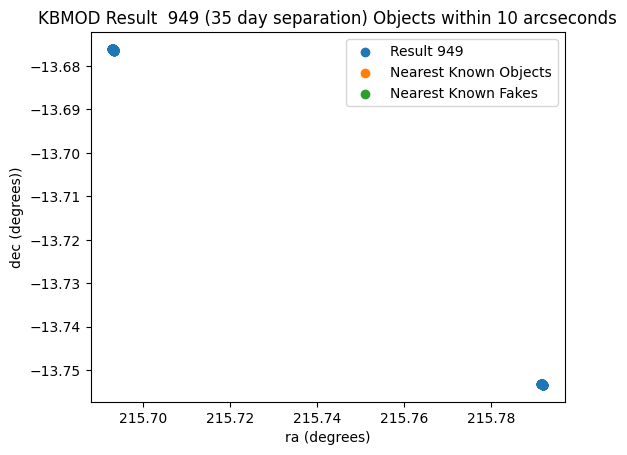

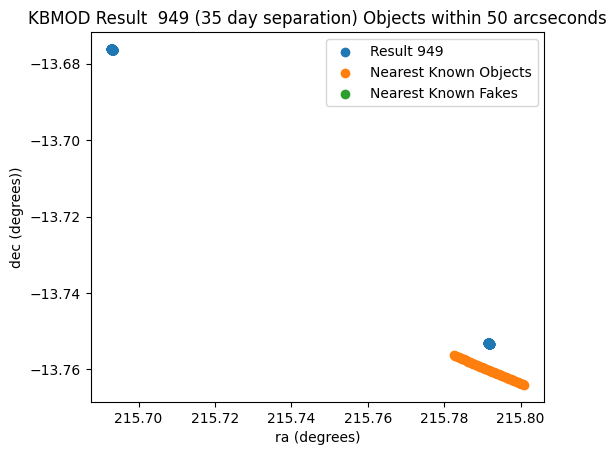

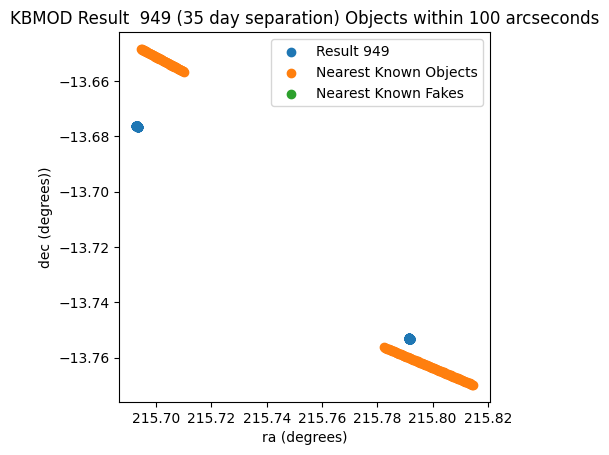

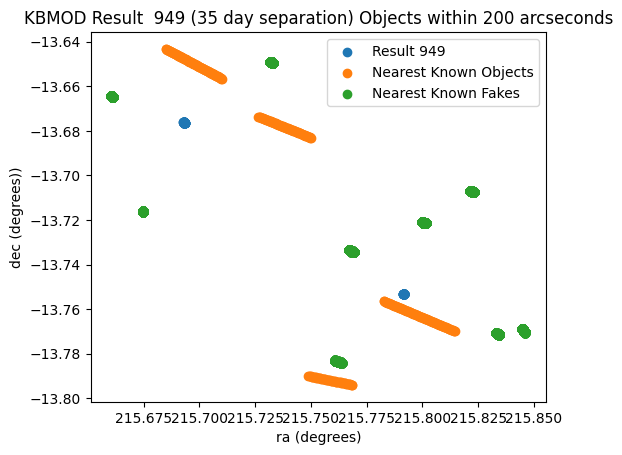

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


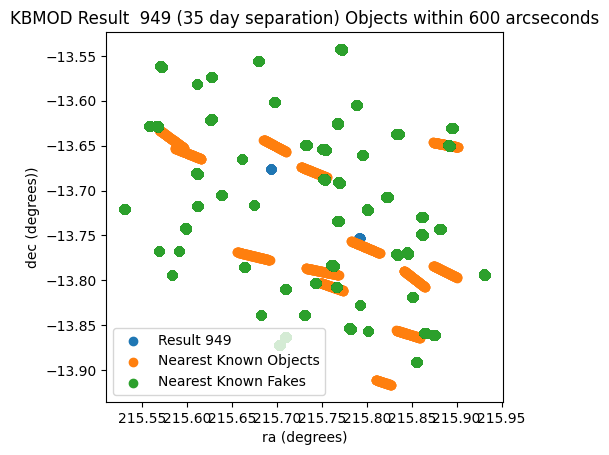

In [44]:
# For each separation limit in arcseconds, generate the plot.
for seplimit in [10, 50, 100, 200, 600]:
    plot_res_with_nearby_objs(results, 949, trajectories, fakes, known_objects, "RA_42.0", "Dec_42.0", seplimit)

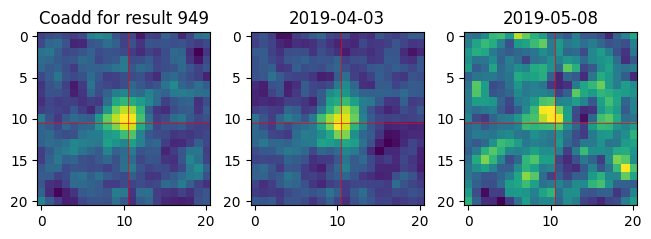

In [50]:
plot_daily_coadds(results, 949)

In [45]:
multi_night_results = []
for i in range(len(results)):
    if results[i]["num_days"] >= 2:
        multi_night_results.append(i)
        
# Lol what a name
possible_discovery = []
for i in multi_night_results:
    if i not in result_start_to_fakes and i not in result_end_to_fakes:
        possible_discovery.append(i)
        
print(len(possible_discovery))
possible_discovery
        

35


[62,
 266,
 313,
 315,
 322,
 339,
 363,
 365,
 377,
 456,
 467,
 622,
 638,
 639,
 649,
 685,
 740,
 768,
 810,
 819,
 821,
 875,
 949,
 957,
 959,
 968,
 986,
 1016,
 1024,
 1028,
 1032,
 1043,
 1049,
 1055,
 1089]

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/kbmod/analysis/plotting.py:448: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(layout="constrained")


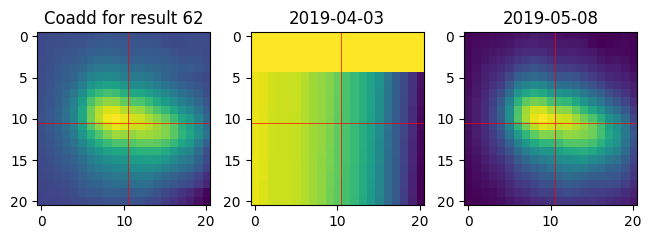

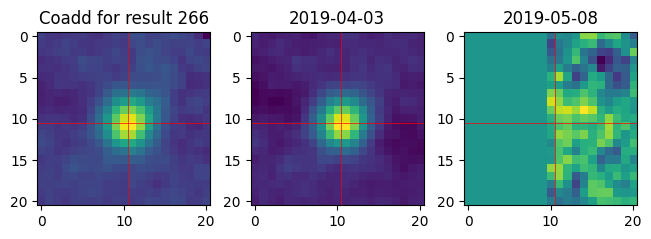

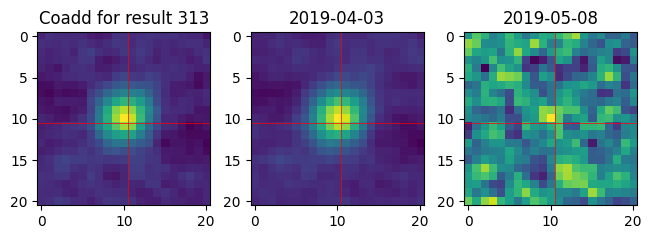

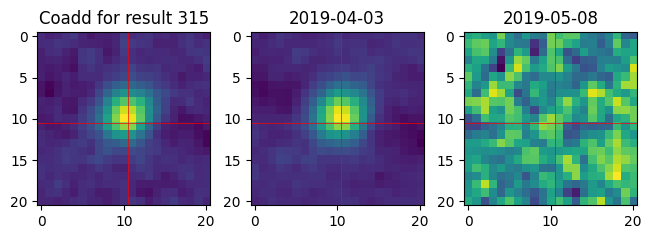

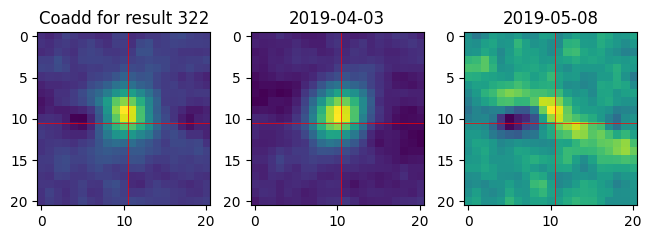

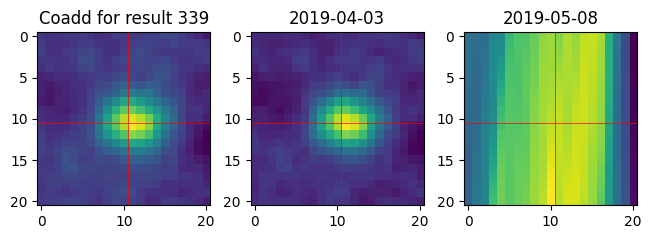

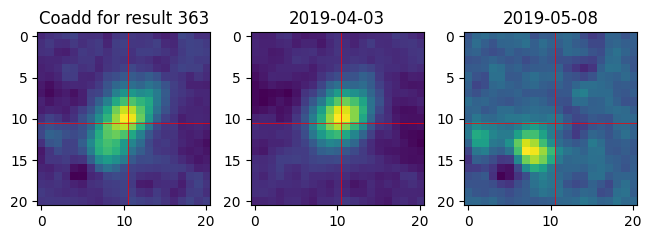

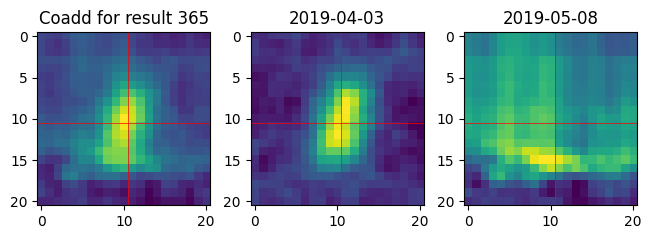

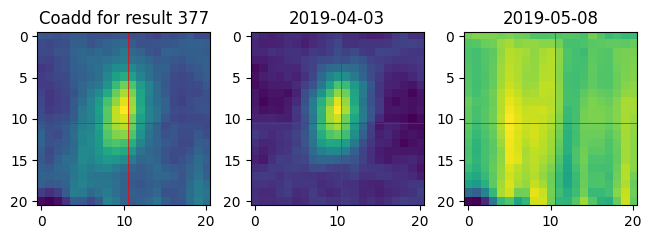

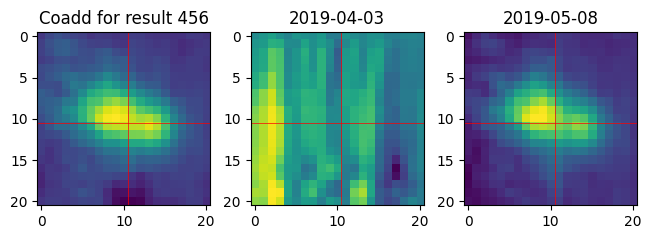

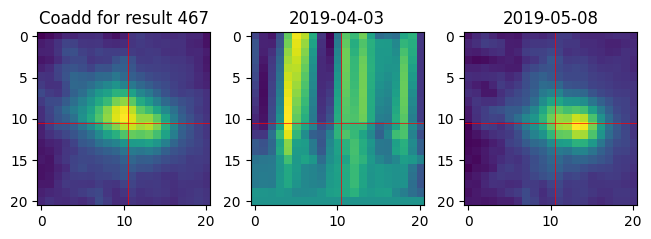

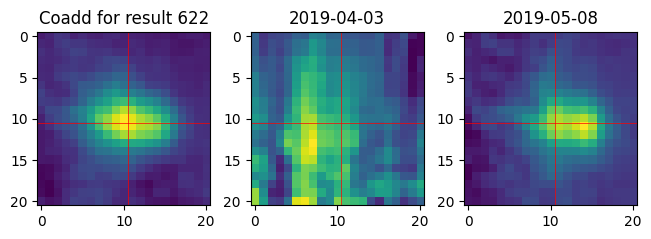

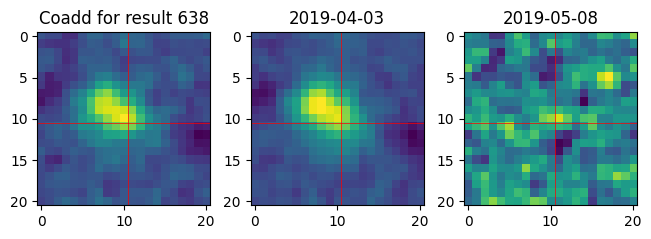

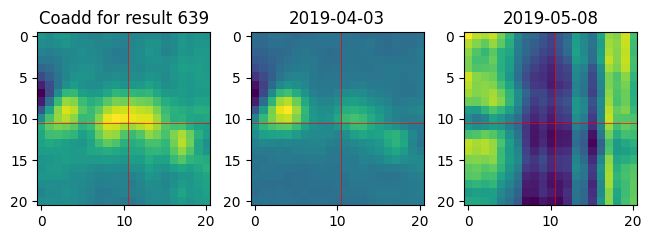

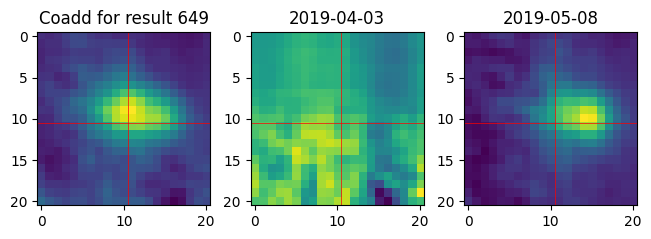

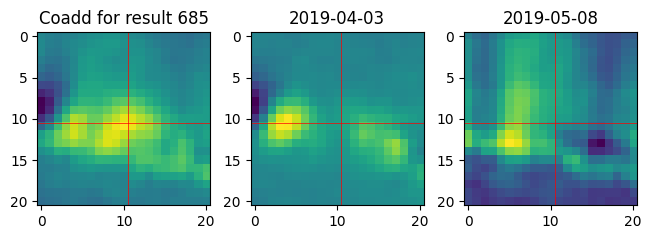

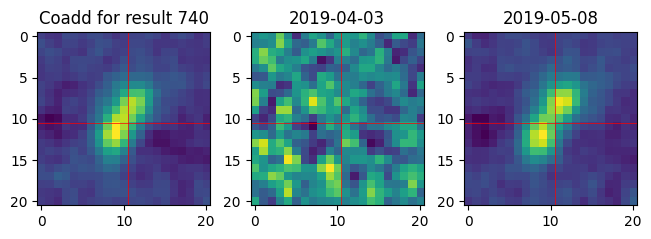

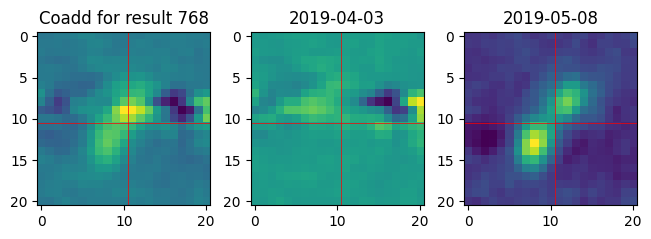

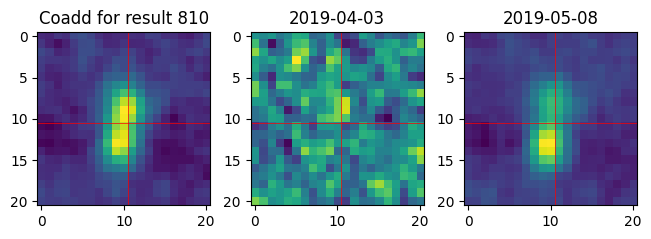

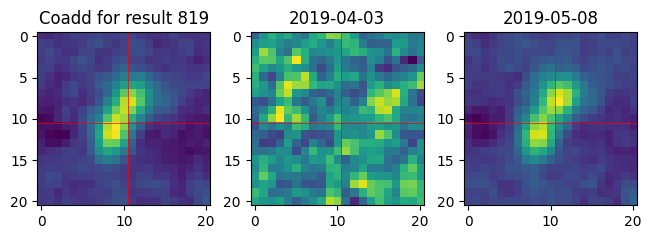

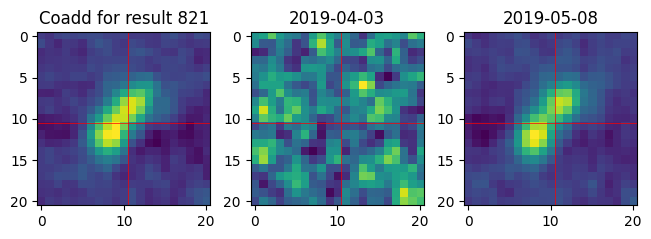

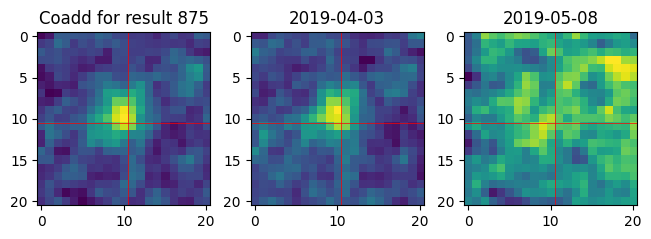

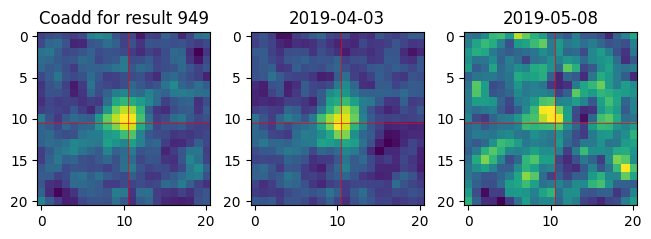

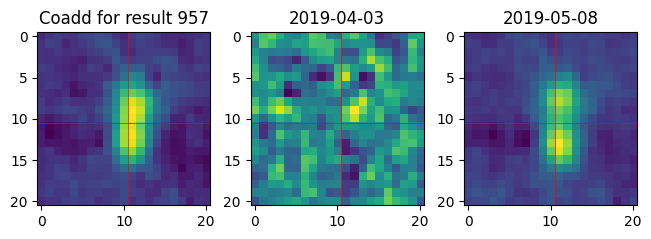

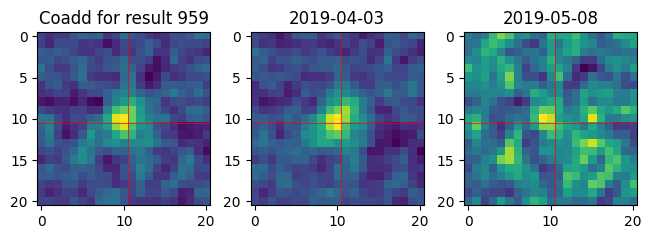

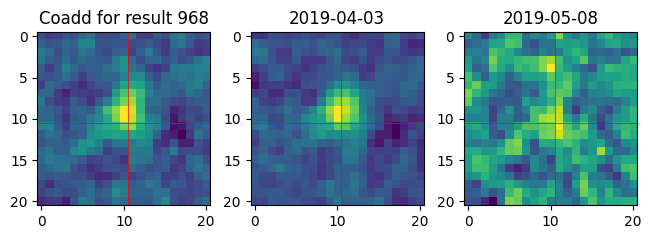

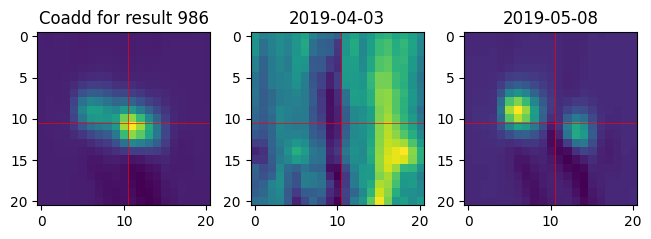

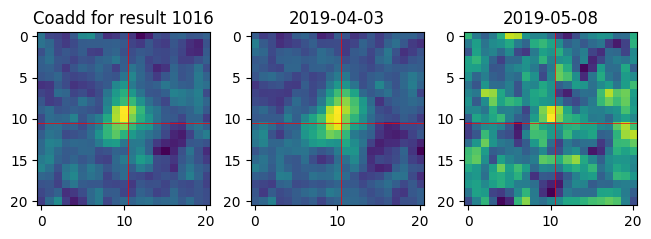

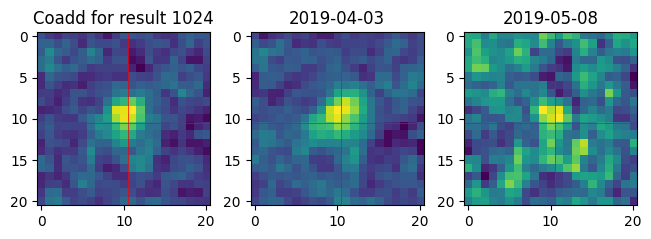

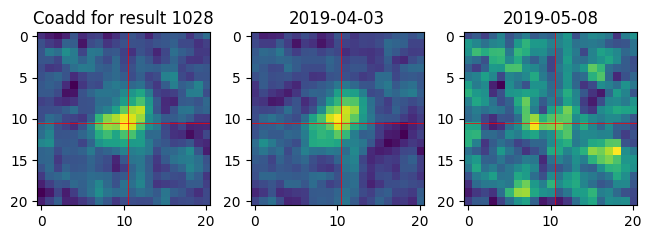

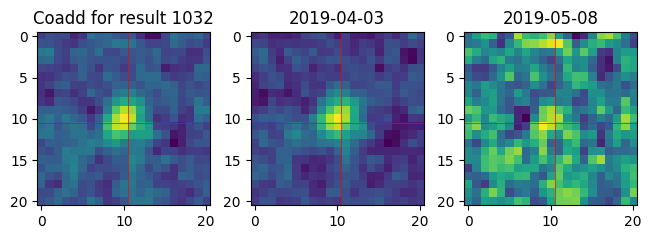

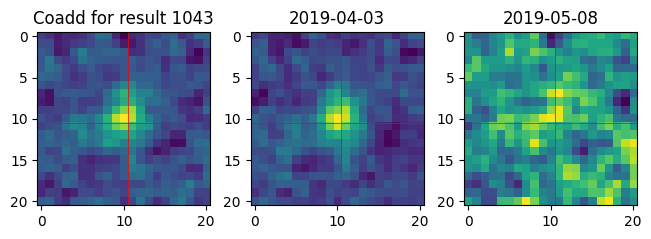

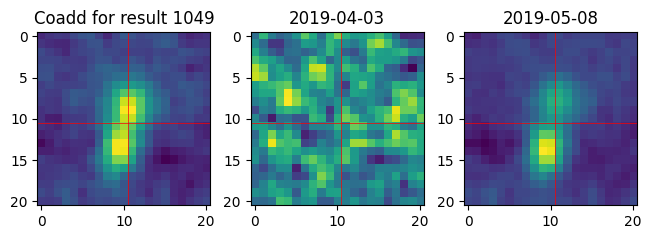

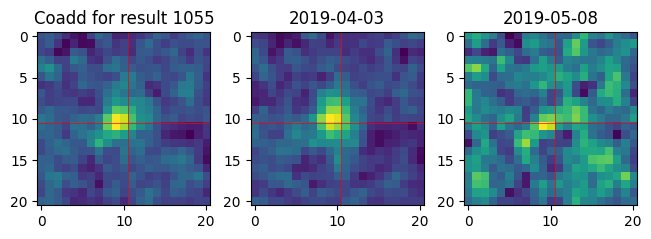

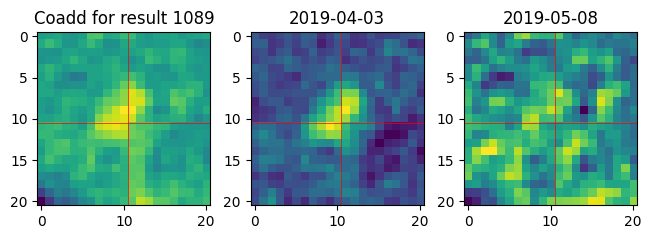

In [48]:
for idx in possible_discovery:
    plot_daily_coadds(results, idx)

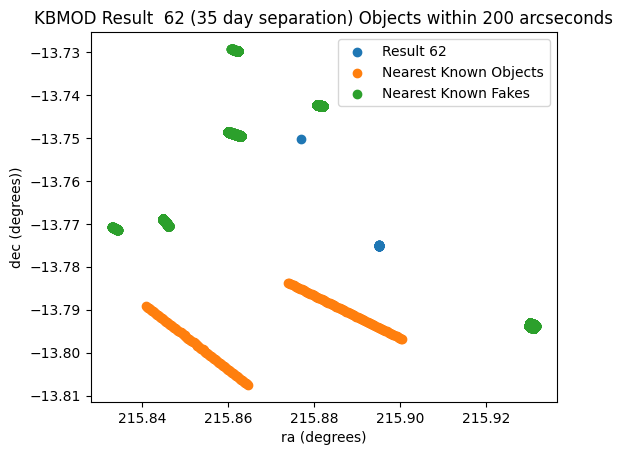

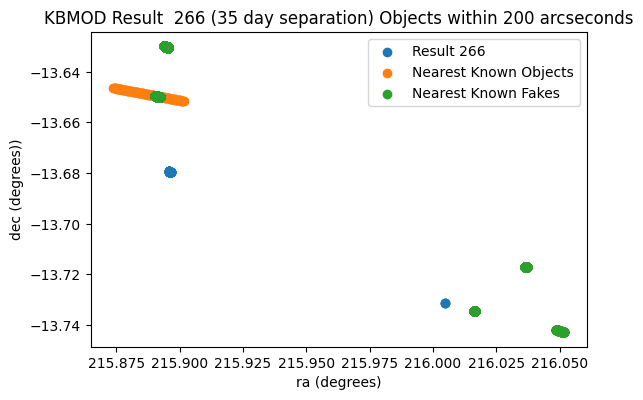

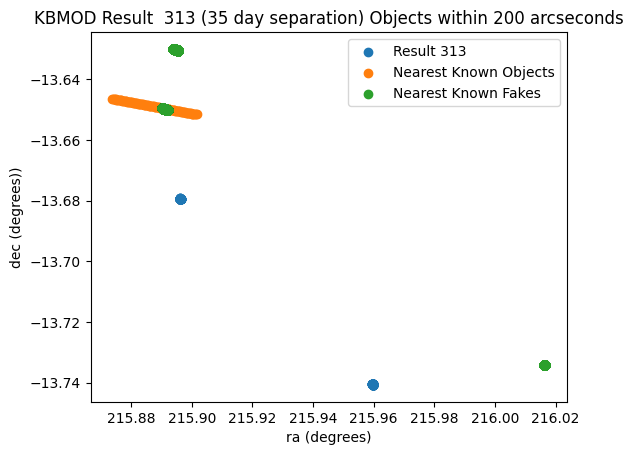

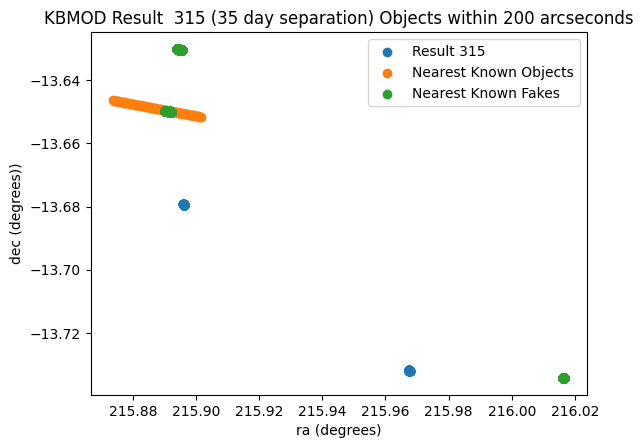

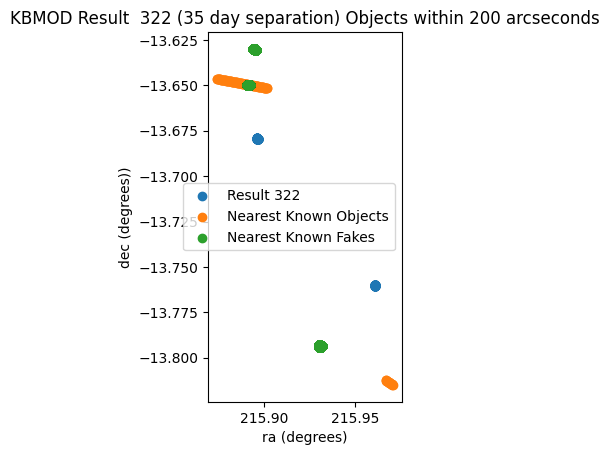

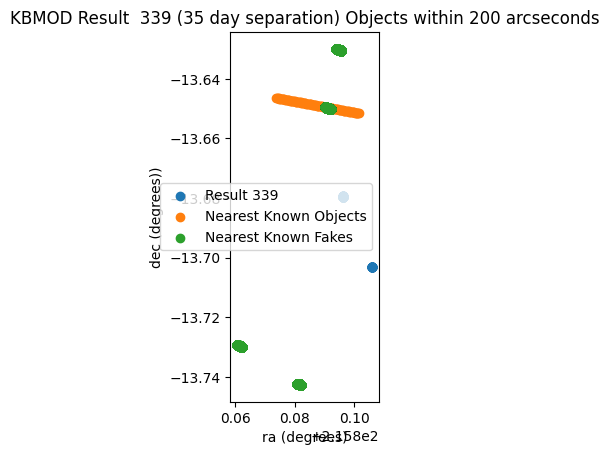

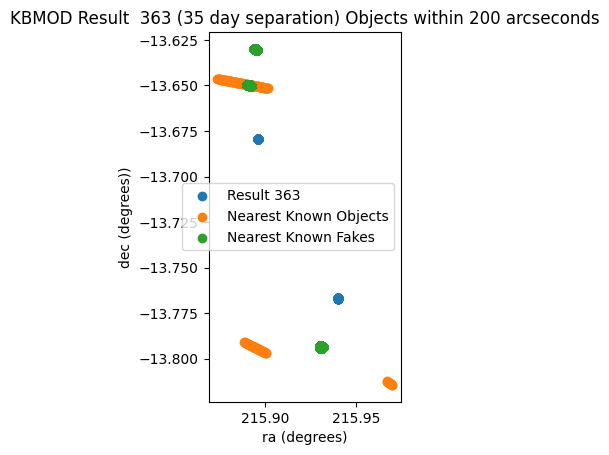

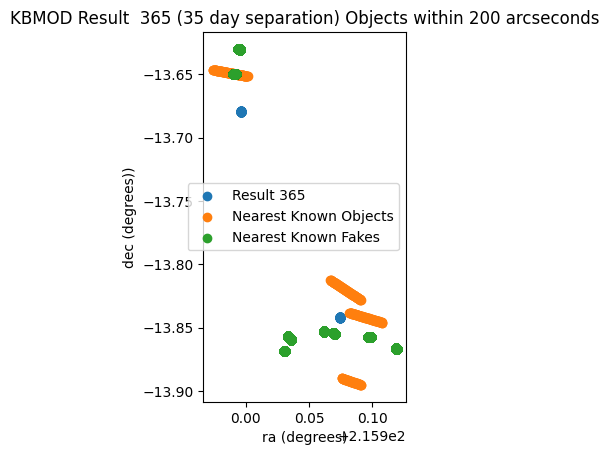

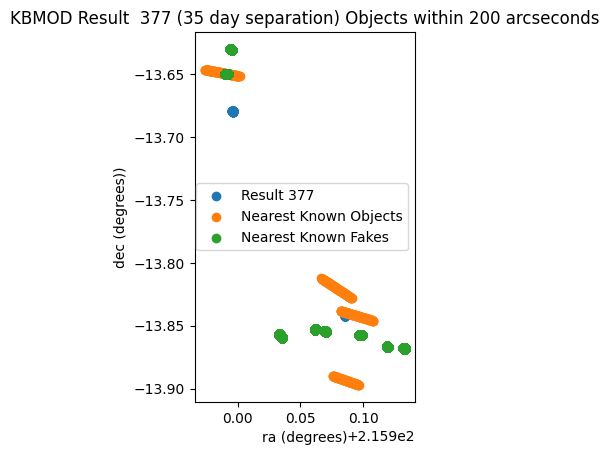

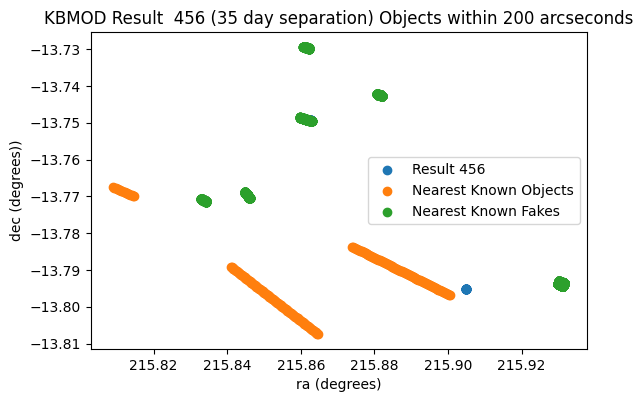

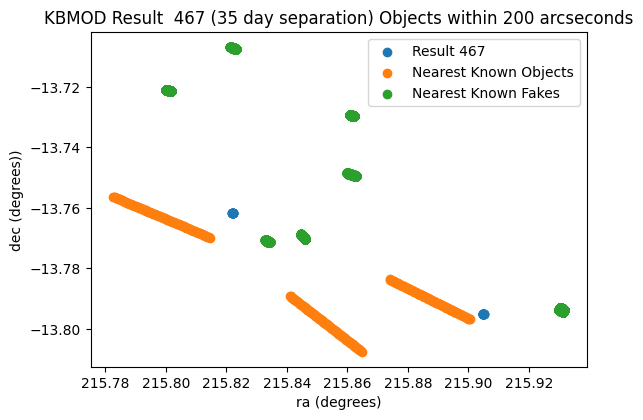

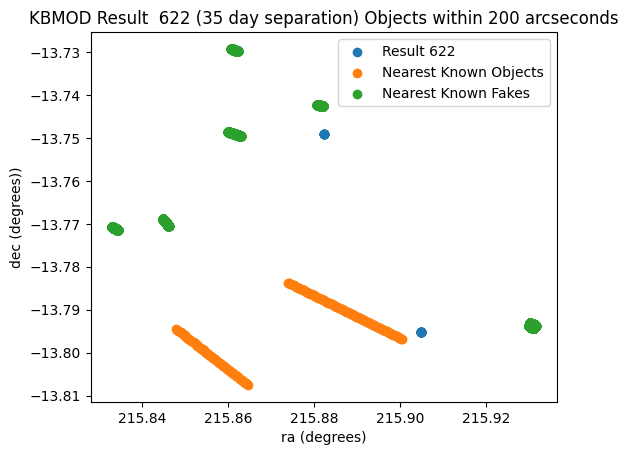

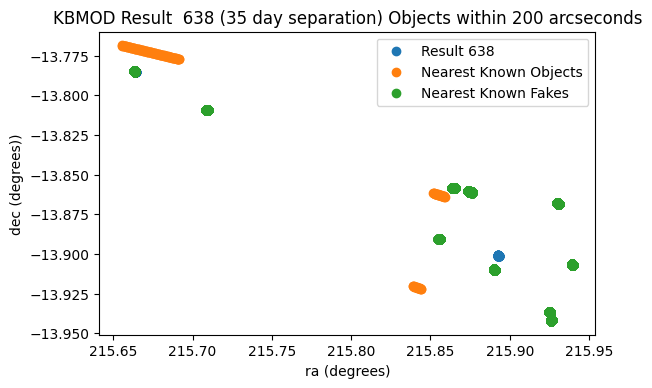

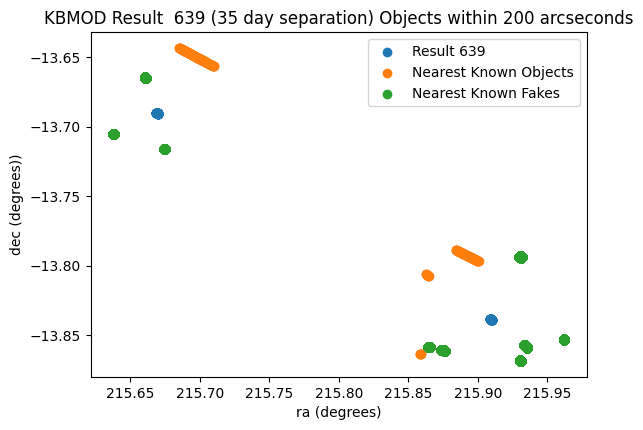

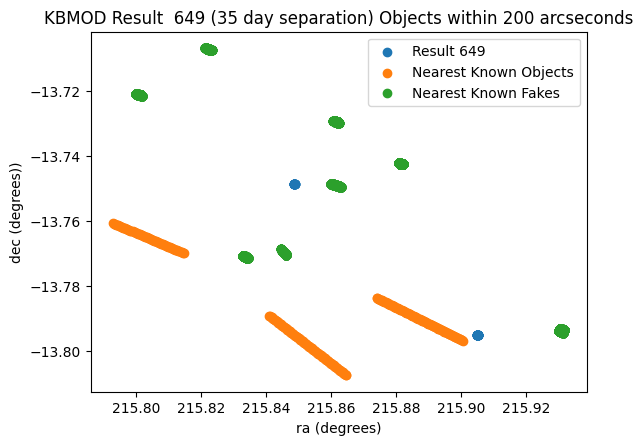

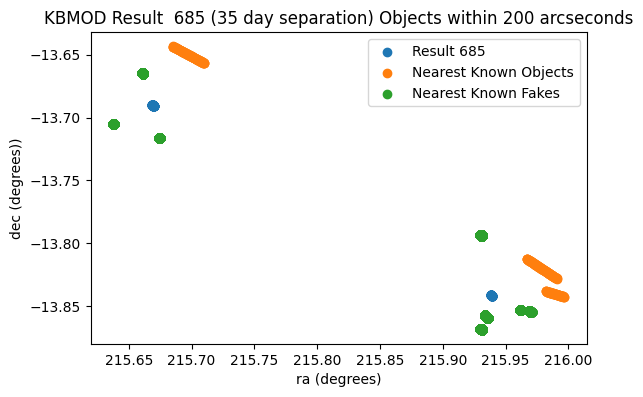

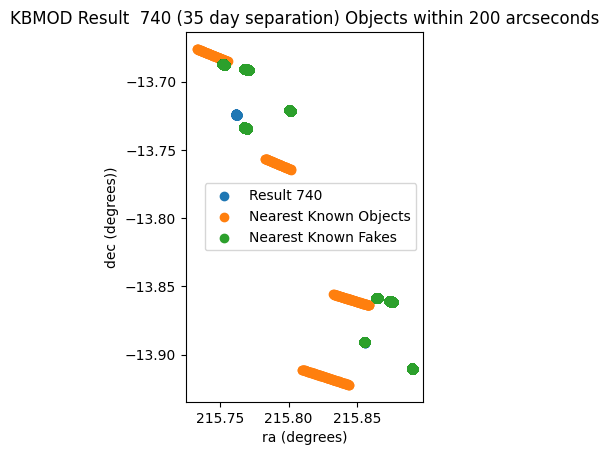

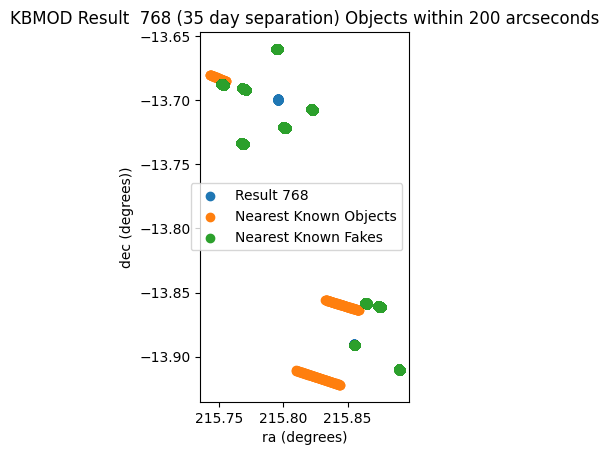

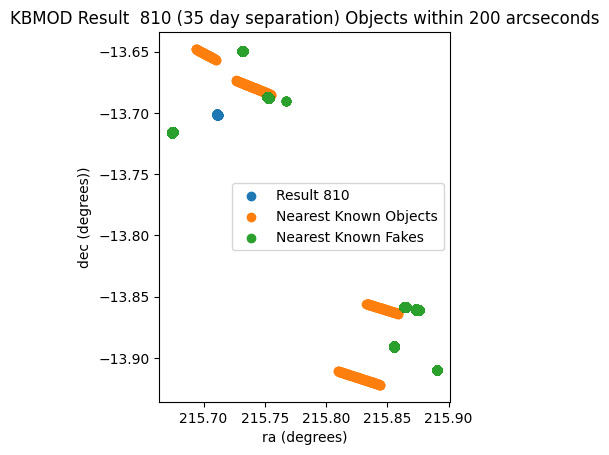

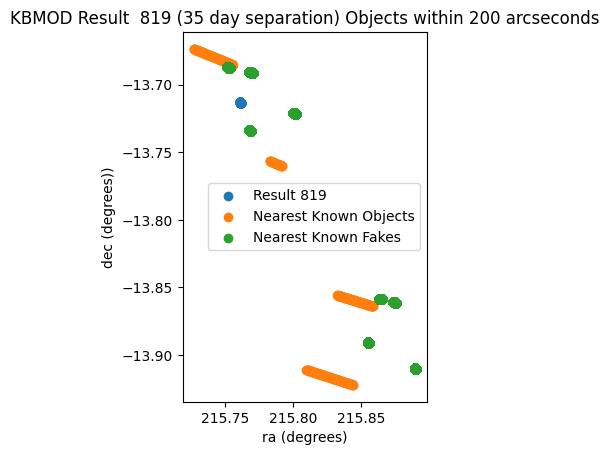

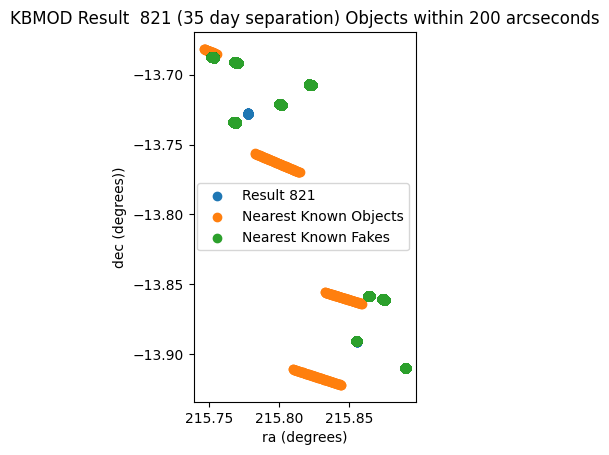

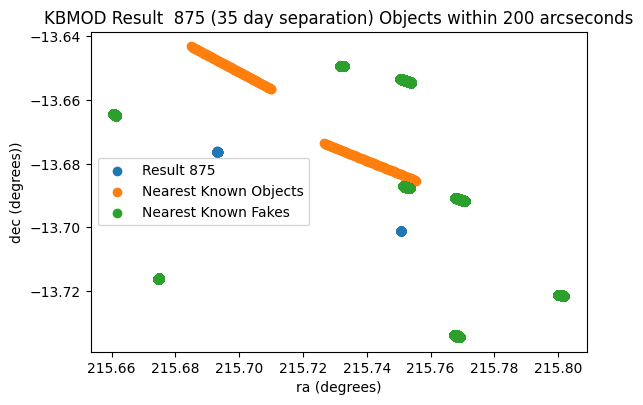

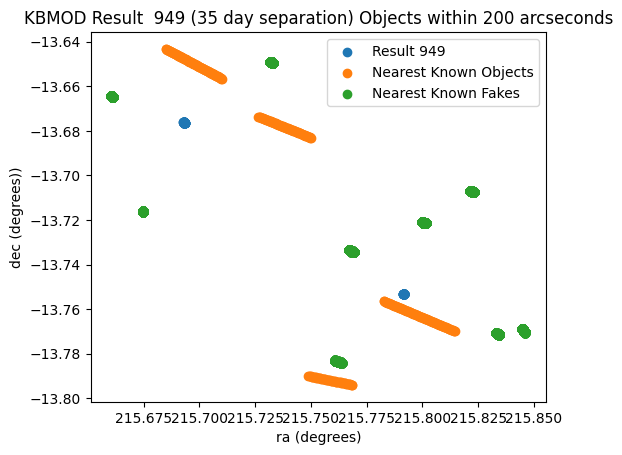

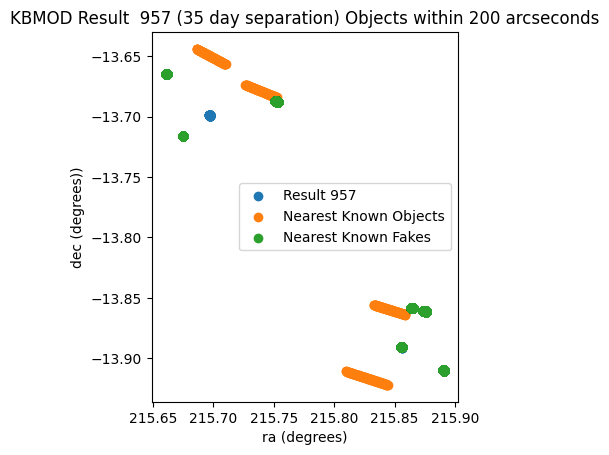

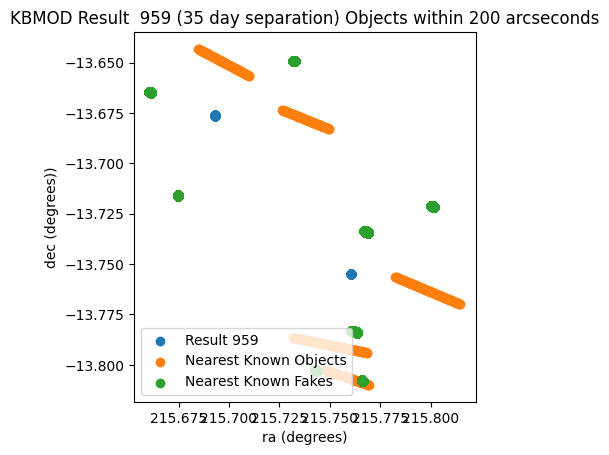

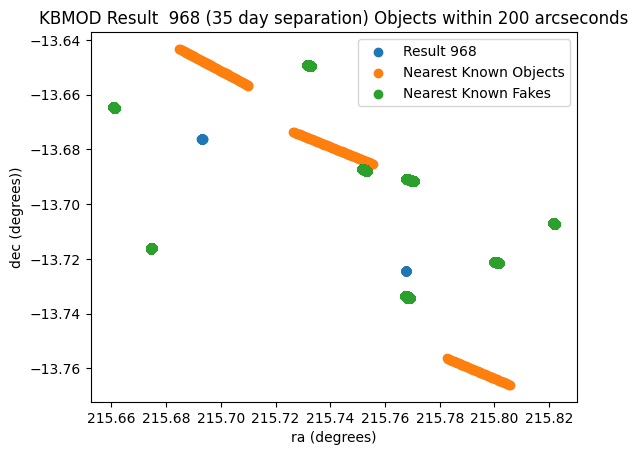

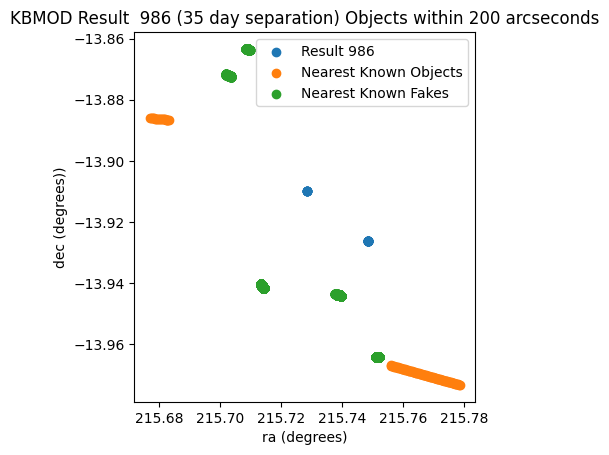

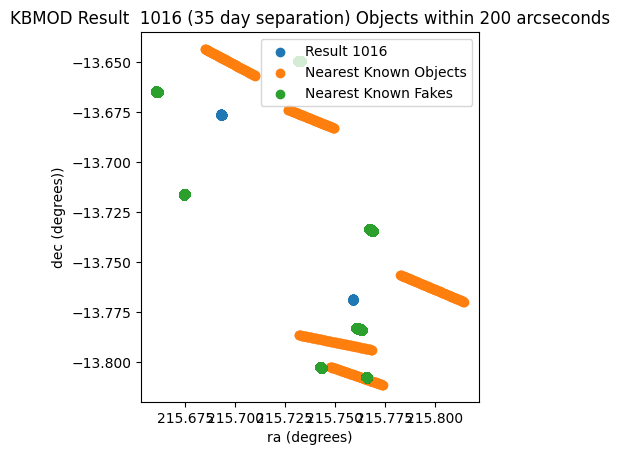

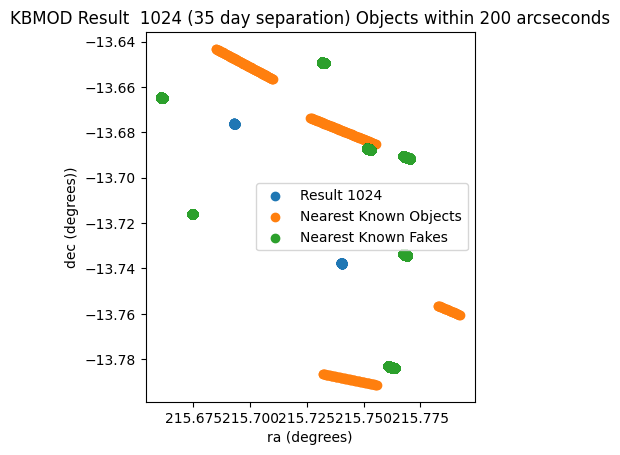

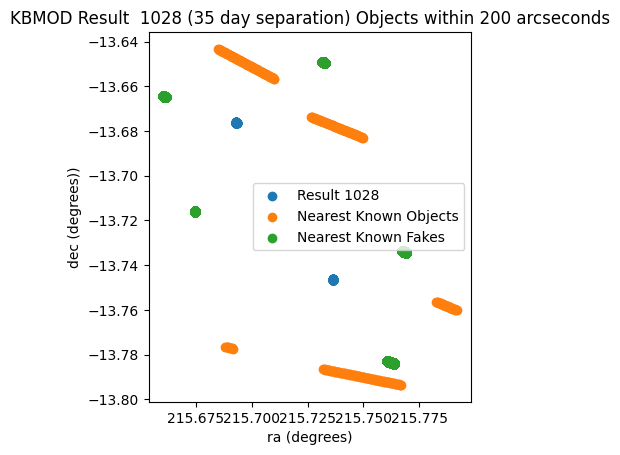

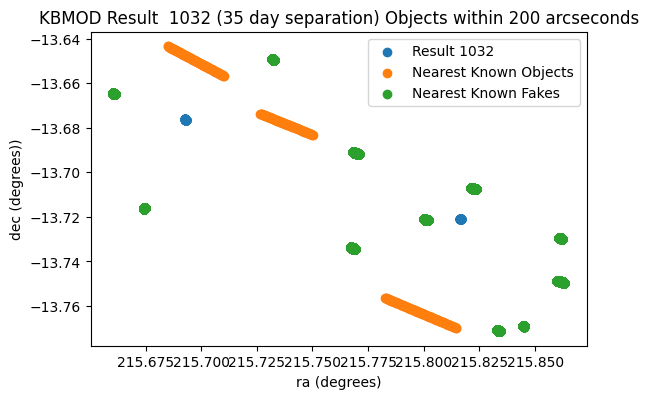

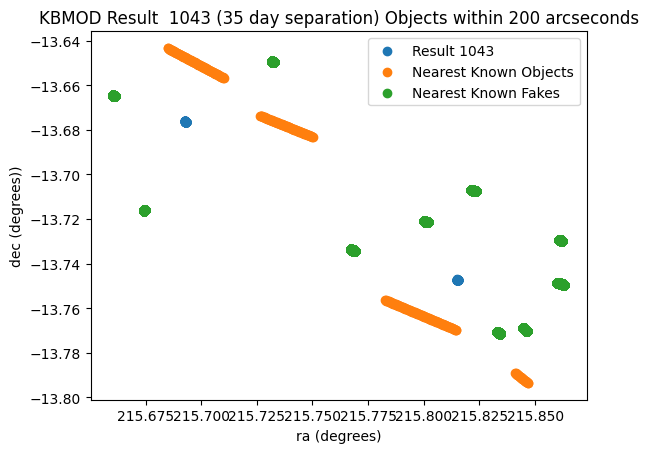

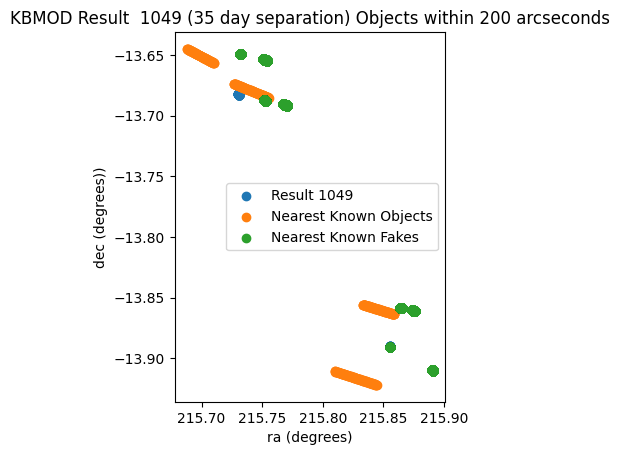

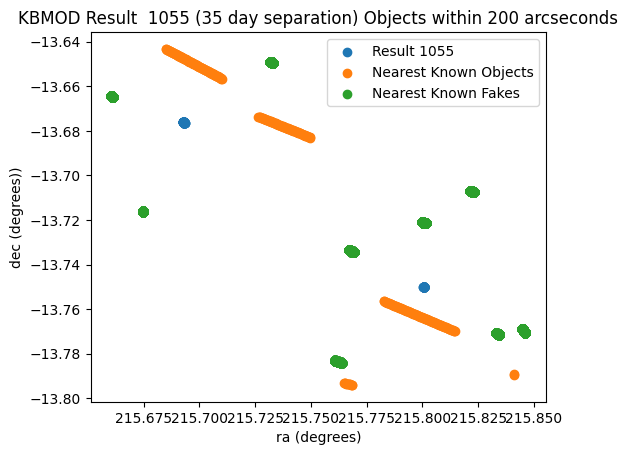

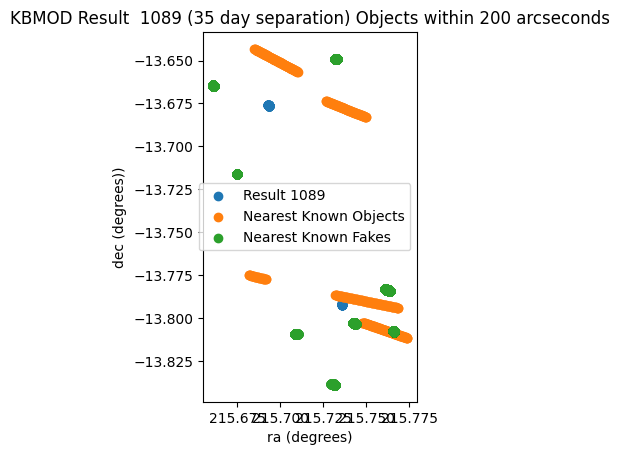

In [49]:
# For each separation limit in arcseconds, generate the plot.
for idx in possible_discovery:
    plot_res_with_nearby_objs(results, idx, trajectories, fakes, known_objects, "RA_42.0", "Dec_42.0", 200)